**Commit hashes for this experiment:**  
`is3-broker-java`: 56f40211  
`is3-broker-rl`: 538bc1d3

**Notes:**  
Reward shaping with small action penalty and penalty for 50% retail market share target.  
Bivariate action space (with a single NO_OP action only).  
Customer groups with subscription share.

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib_inline
import numpy as np
import pandas as pd
import seaborn as sns

import is3_broker_rl
from is3_broker_rl.api import TariffRateAction, Reward

%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats("retina")
sns.set_style("whitegrid")

In [2]:
DATA_DIR = Path(is3_broker_rl.__file__).parent.parent / "data"

In [3]:
# Papermill parameter cell
# Name of the directory to analyse. Should contain consumption_action.csv and consumption_reward.csv.
ANALYSIS_DIR_NAME = ""

In [4]:
# Parameters
ANALYSIS_DIR_NAME = "trial4_consumption_training4"

In [5]:
ANALYSIS_DIR = DATA_DIR / ANALYSIS_DIR_NAME

In [6]:
df_action = pd.read_csv(ANALYSIS_DIR / "consumption_action.csv")
df_reward = pd.read_csv(ANALYSIS_DIR / "consumption_reward.csv")

In [7]:
# The episode_length is 168 and we use a rolling mean of 50 to make sure that no outliers are detected as argmax.
# Learning starts after 500 actions, so we only consider data from the df_reward after 500 actions have been seen.
max_reward_index = (
    df_reward.iloc[500 * 14 :].groupby("episode_id", sort=False).mean()["reward"].rolling(50).mean().argmax() * 168 + 50
)
df_reward = df_reward.iloc[:max_reward_index]
df_action = df_action.iloc[: int(max_reward_index / 14)]

In [8]:
ACTION_VALUE_MAPPING = {a.name: a.value for a in TariffRateAction}

In [9]:
# Fixes the issue that the experiment scheduler always assigns the same gameId
def write_unique_game_id(df):
    new_game_start_indices = df[df["timeslot"] < df["timeslot"].shift()].index
    if len(new_game_start_indices) > 0:
        df.loc[: new_game_start_indices[0], "gameId"] = f"game0"
        for i in range(len(new_game_start_indices) - 1):
            df.loc[new_game_start_indices[i] : new_game_start_indices[i + 1], "gameId"] = f"game{i + 1}"
        df.loc[new_game_start_indices[-1] :, "gameId"] = f"game{len(new_game_start_indices)}"

In [10]:
write_unique_game_id(df_reward)
write_unique_game_id(df_action)

In [11]:
def plot_action_counts(df_action):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(21, 7))
    sns.countplot(x="tariff_rate_action", data=df_action.iloc[:500], ax=ax1, order=ACTION_VALUE_MAPPING.values())
    ax1.set_xticklabels(ACTION_VALUE_MAPPING.keys())
    ax1.set_xlabel("Action type")
    ax1.set_ylabel("Count")
    ax1.set_title("Action distribution of the first 500 actions (before learning)")
    sns.countplot(x="tariff_rate_action", data=df_action.iloc[-500:], ax=ax2, order=ACTION_VALUE_MAPPING.values())
    ax2.set_xticklabels(ACTION_VALUE_MAPPING.keys())
    ax2.set_xlabel("Action type")
    ax2.set_ylabel("Count")
    ax2.set_title("Action distribution of the last 500 actions (during and after learning)")

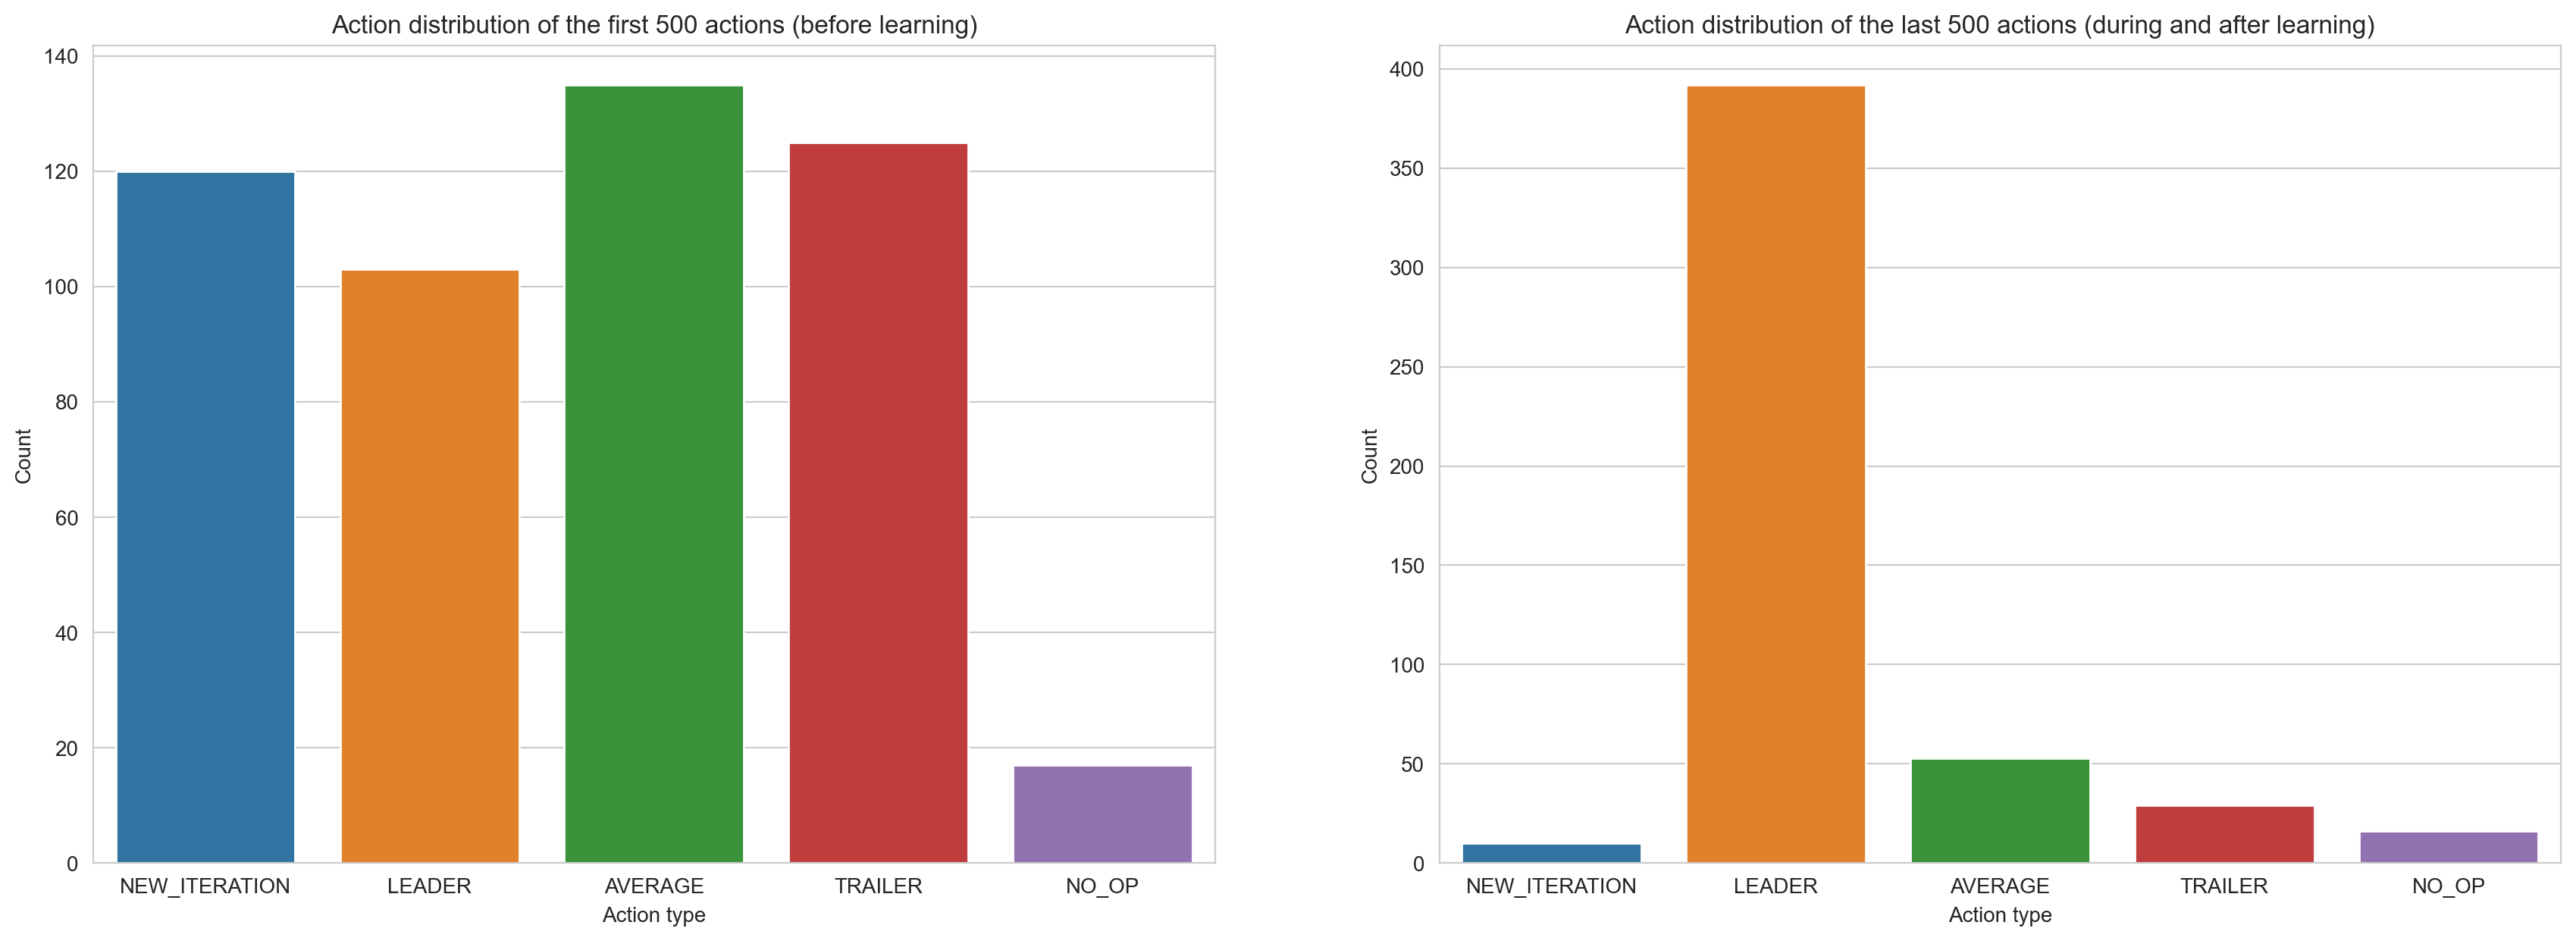

In [12]:
plot_action_counts(df_action)

In [13]:
def plot_action_counts_within_game(df_action):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(21, 7))

    def draw_plot(df, title, ax):
        sns.scatterplot(
            x="timeslot",
            y="tariff_rate_action",
            data=df,
            ax=ax,
            hue="ppf_action",
            palette="rocket_r",
            s=75,
        )
        ax.set_ylabel(None)
        ax.set_yticks(list(reversed(ACTION_VALUE_MAPPING.values())))
        ax.set_yticklabels(reversed(ACTION_VALUE_MAPPING.keys()))
        ax.set_title(title)
        ax.legend(title="PPF action")

    draw_plot(
        df_action[df_action["gameId"] == df_action.iloc[0]["gameId"]],
        "Actions within the first game (before learning)",
        ax1,
    )
    draw_plot(
        df_action[df_action["gameId"] == df_action.iloc[-1]["gameId"]],
        "Actions within the last game (after learning)",
        ax2,
    )

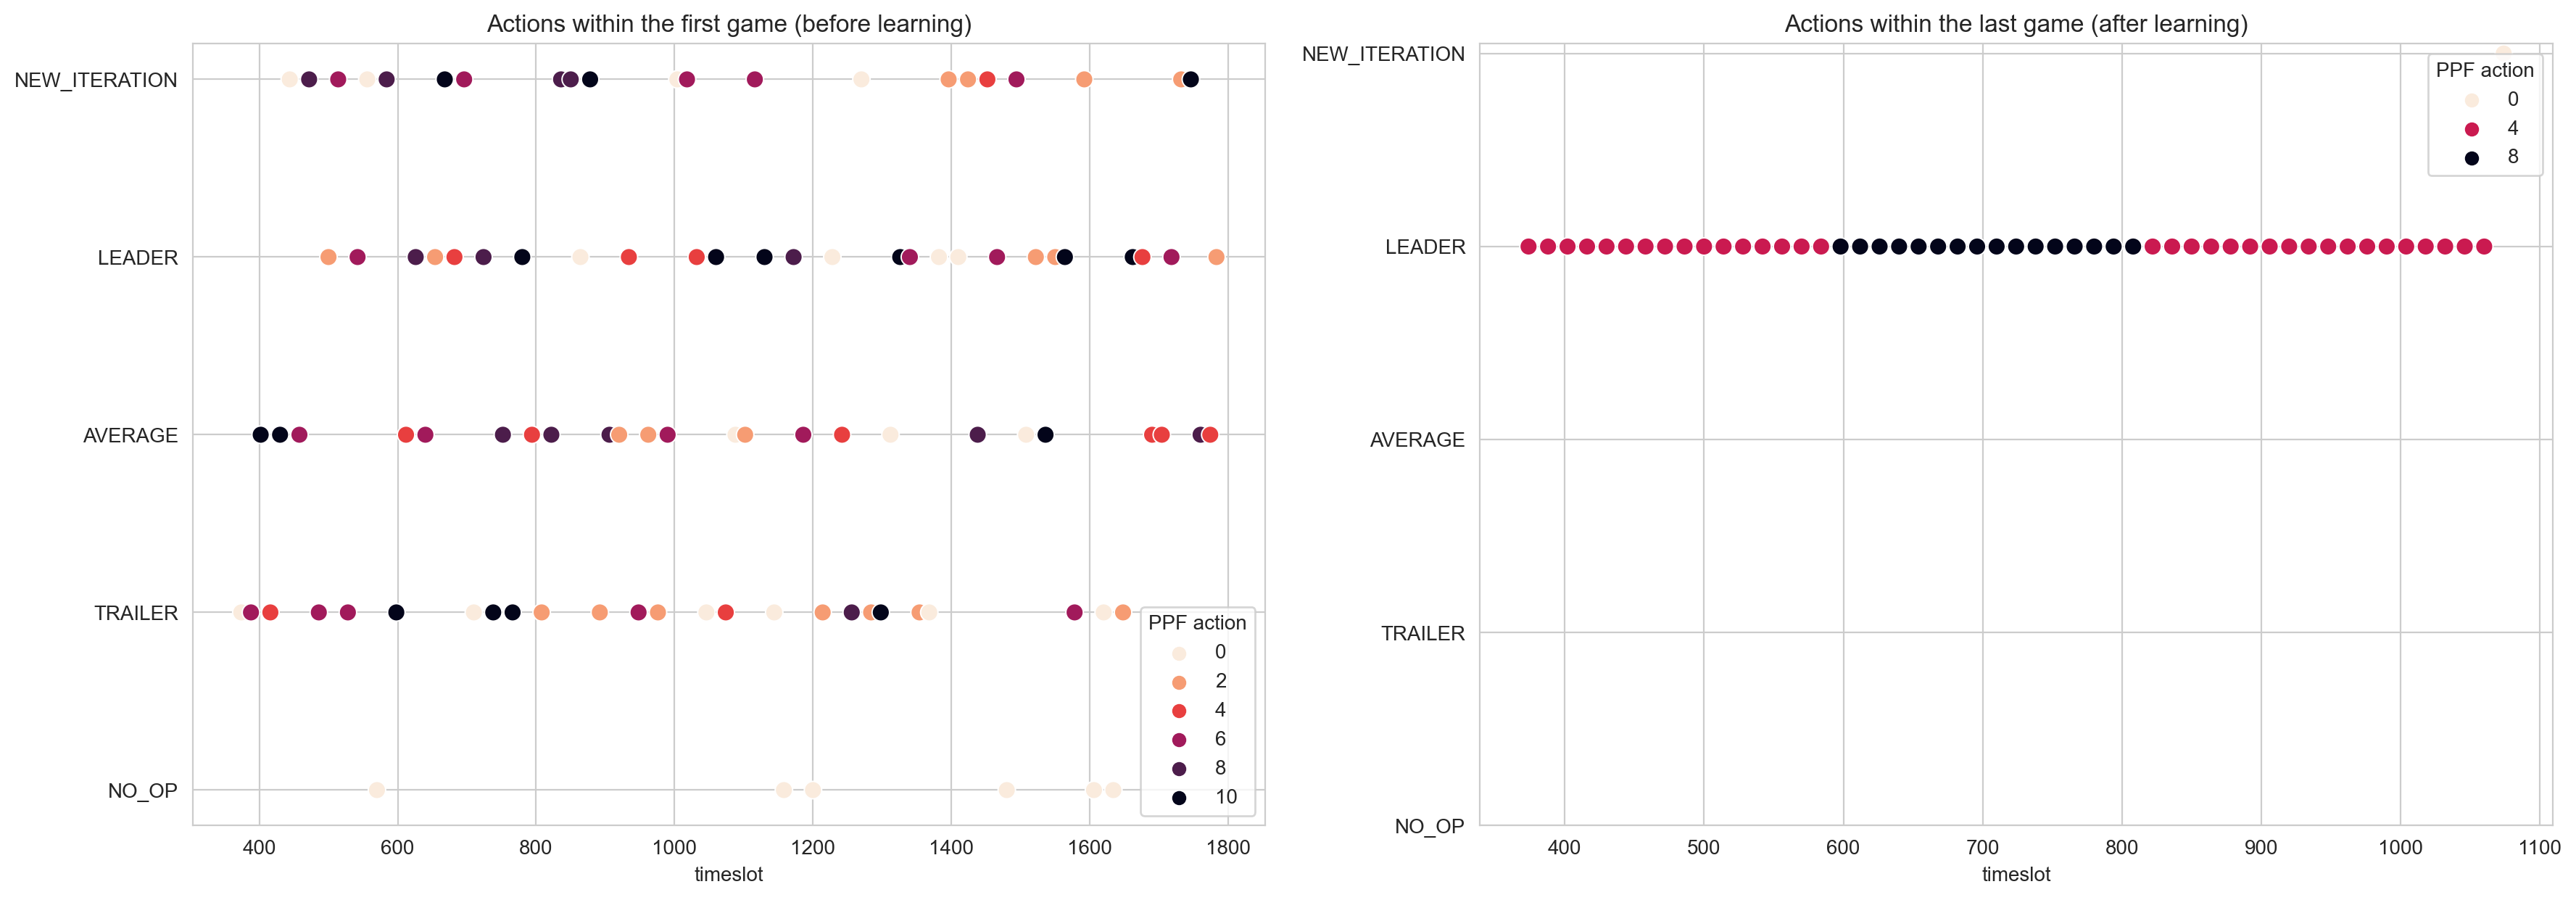

In [14]:
plot_action_counts_within_game(df_action)

In [15]:
def plot_ppf_histogram(df_action):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(21, 7))

    def draw_plot(df, title, ax):
        sns.histplot(data=df, ax=ax, bins=14)
        ax.set_xlabel("PPF action")
        ax.set_title(title)
        ax.set_xticks(range(14))

    draw_plot(
        df_action[df_action["tariff_rate_action"] != TariffRateAction.NO_OP].iloc[:500]["ppf_action"],
        "PPF action distribution of the first 500 actions (before learning)",
        ax1,
    )
    draw_plot(
        df_action[df_action["tariff_rate_action"] != TariffRateAction.NO_OP].iloc[-500:]["ppf_action"],
        "PPF action distribution of the last 500 actions (after learning)",
        ax2,
    )

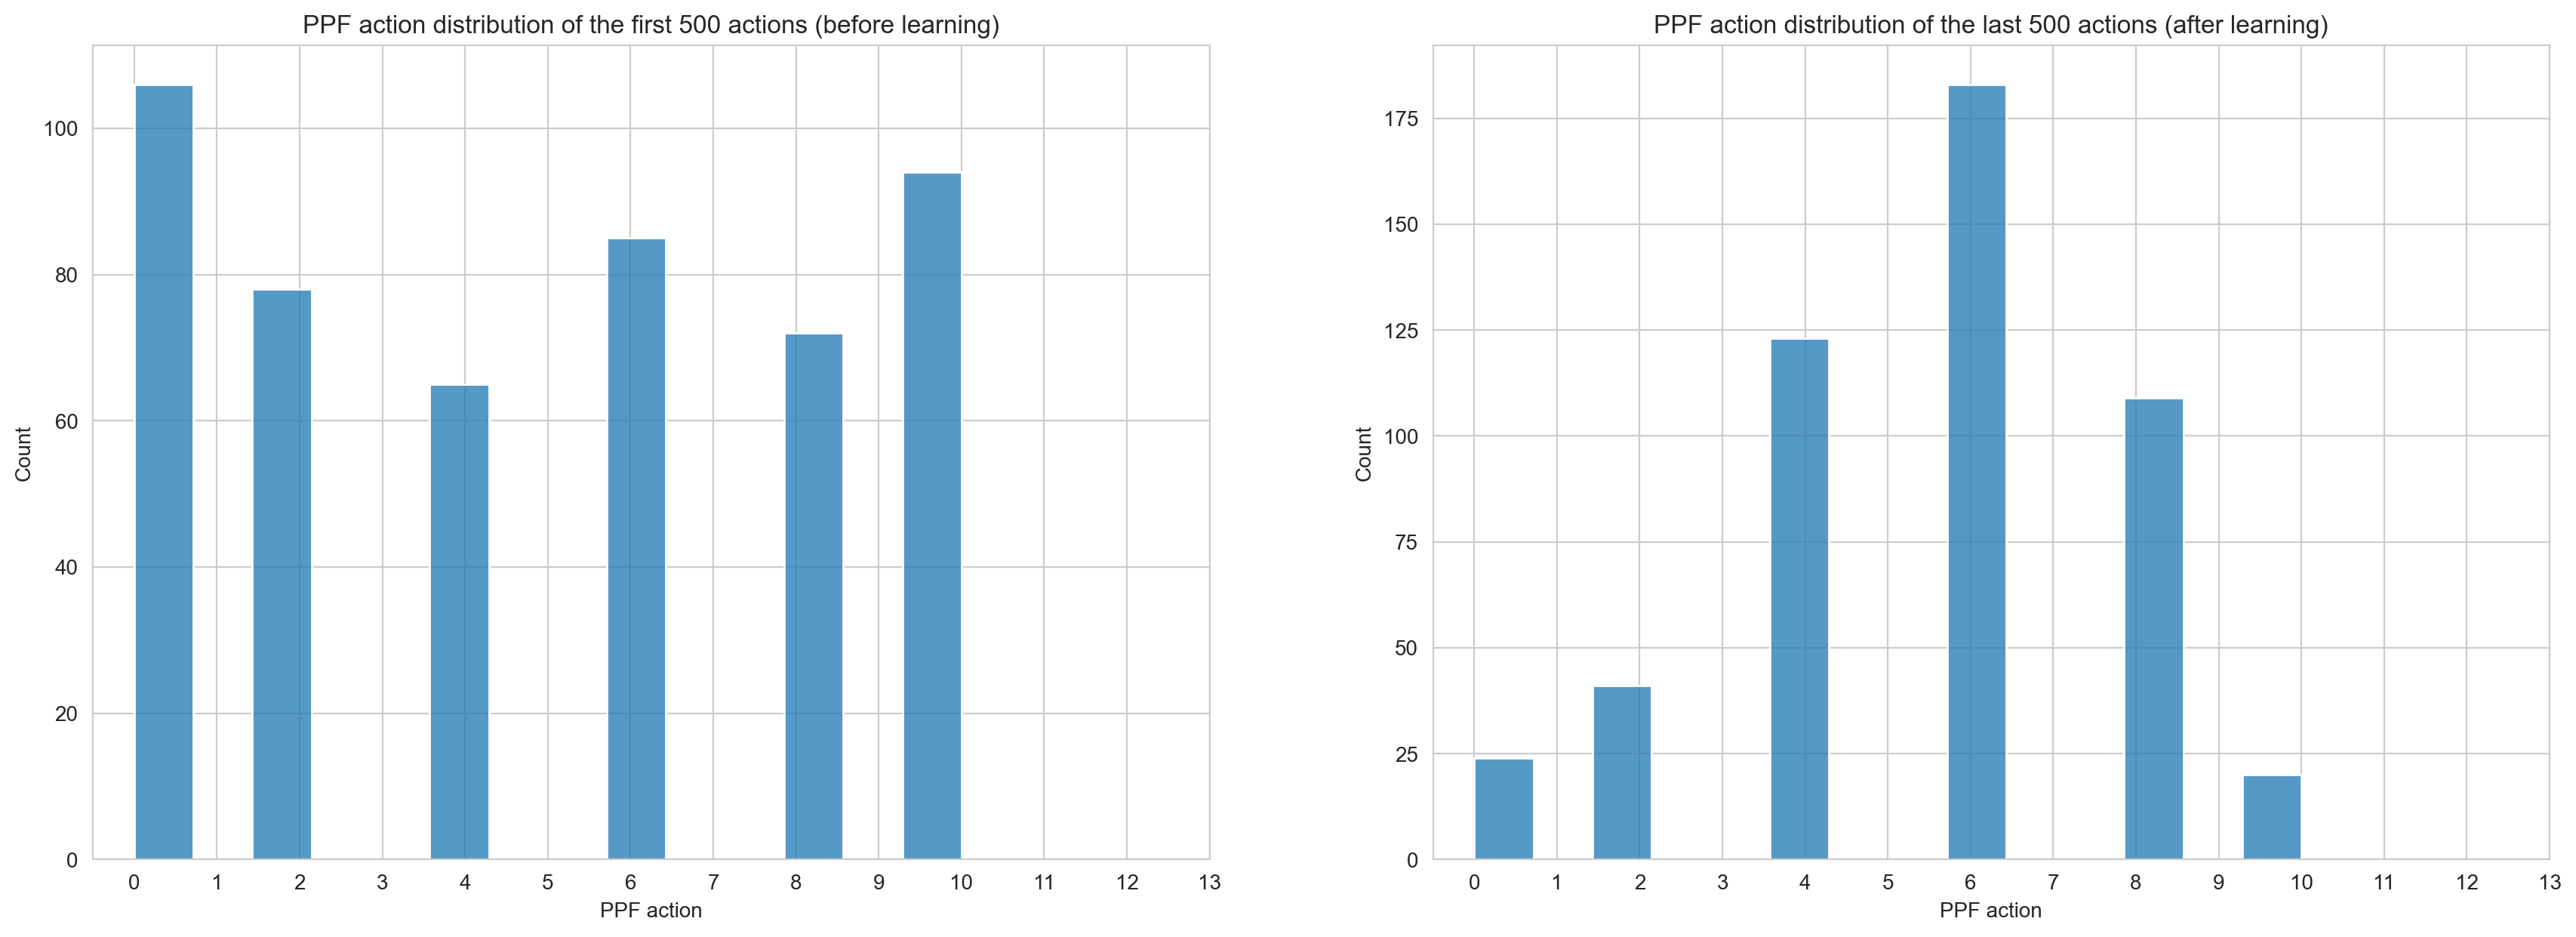

In [16]:
plot_ppf_histogram(df_action)

In [17]:
def plot_joint_distribution(df_action):
    def draw_plot(df, title):
        g = sns.jointplot(
            x="ppf_action",
            y="tariff_rate_action",
            data=df,
            kind="hex",
        )
        g.ax_joint.set_xlabel("PPF action")
        g.ax_joint.set_ylabel(None)
        g.ax_joint.set_yticks(list(reversed(ACTION_VALUE_MAPPING.values())))
        g.ax_joint.set_yticklabels(reversed(ACTION_VALUE_MAPPING.keys()))
        g.figure.suptitle(title)
        g.figure.tight_layout()

    draw_plot(
        df_action[df_action["tariff_rate_action"] != TariffRateAction.NO_OP].iloc[:500],
        "Joint PPF action and tariff rate action distribution for the first 500 actions (before learning)",
    )
    draw_plot(
        df_action[df_action["tariff_rate_action"] != TariffRateAction.NO_OP].iloc[-500:],
        "Joint PPF action and tariff rate action distribution for the last 500 actions (after learning)",
    )

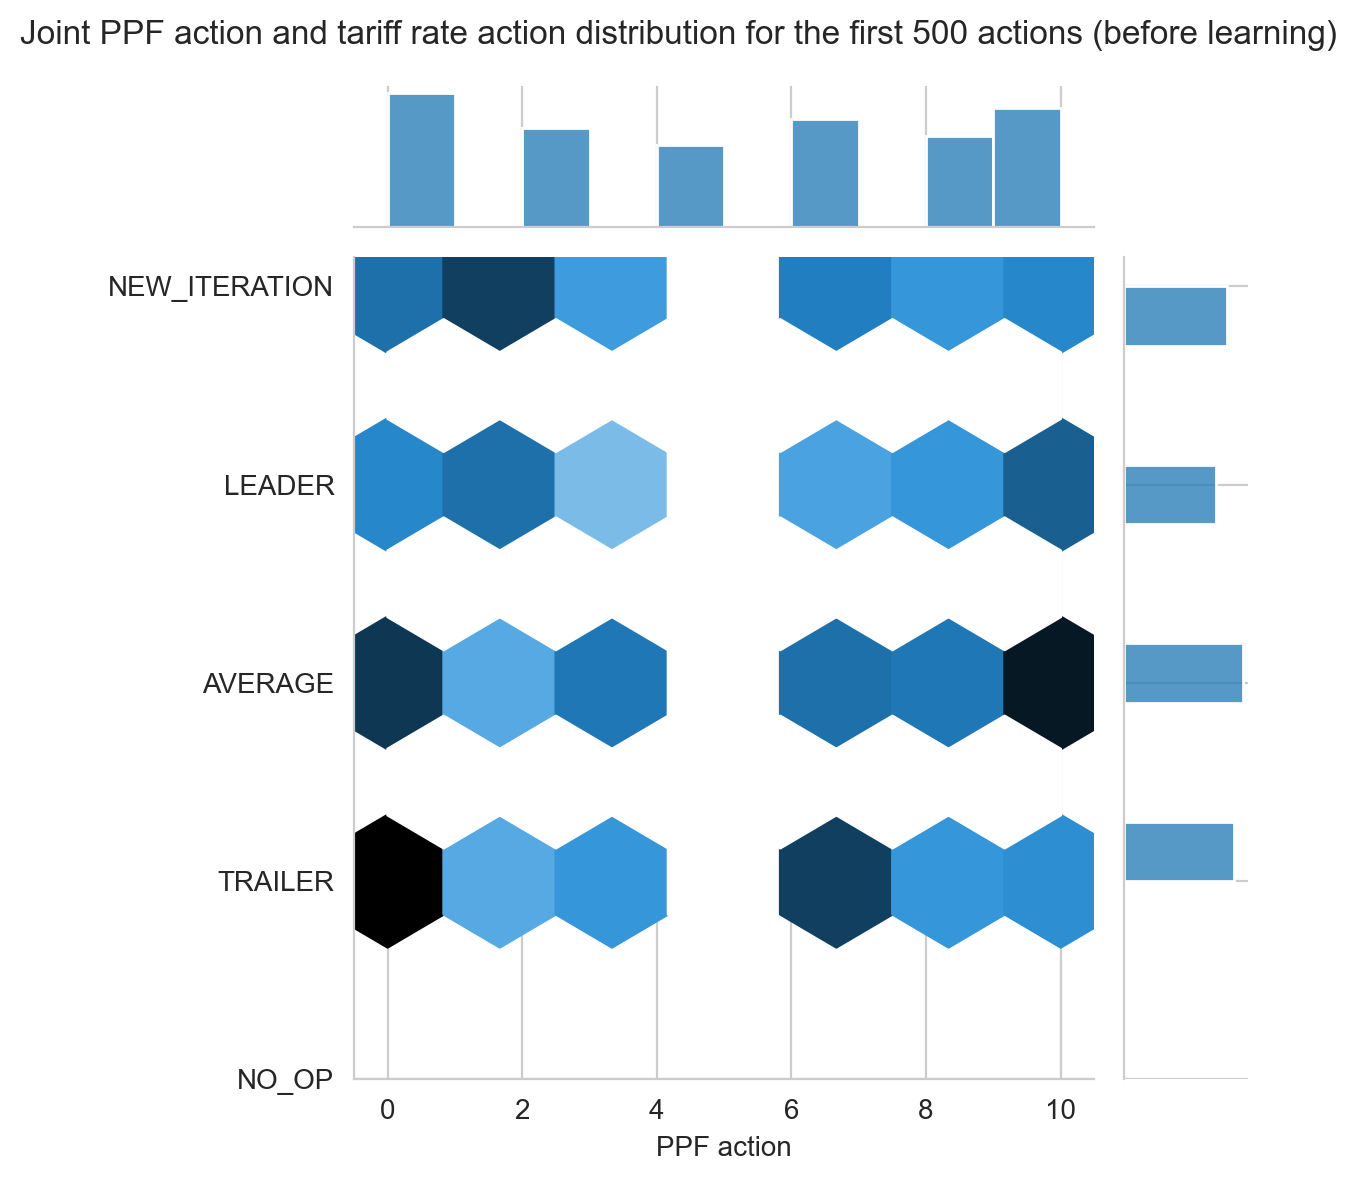

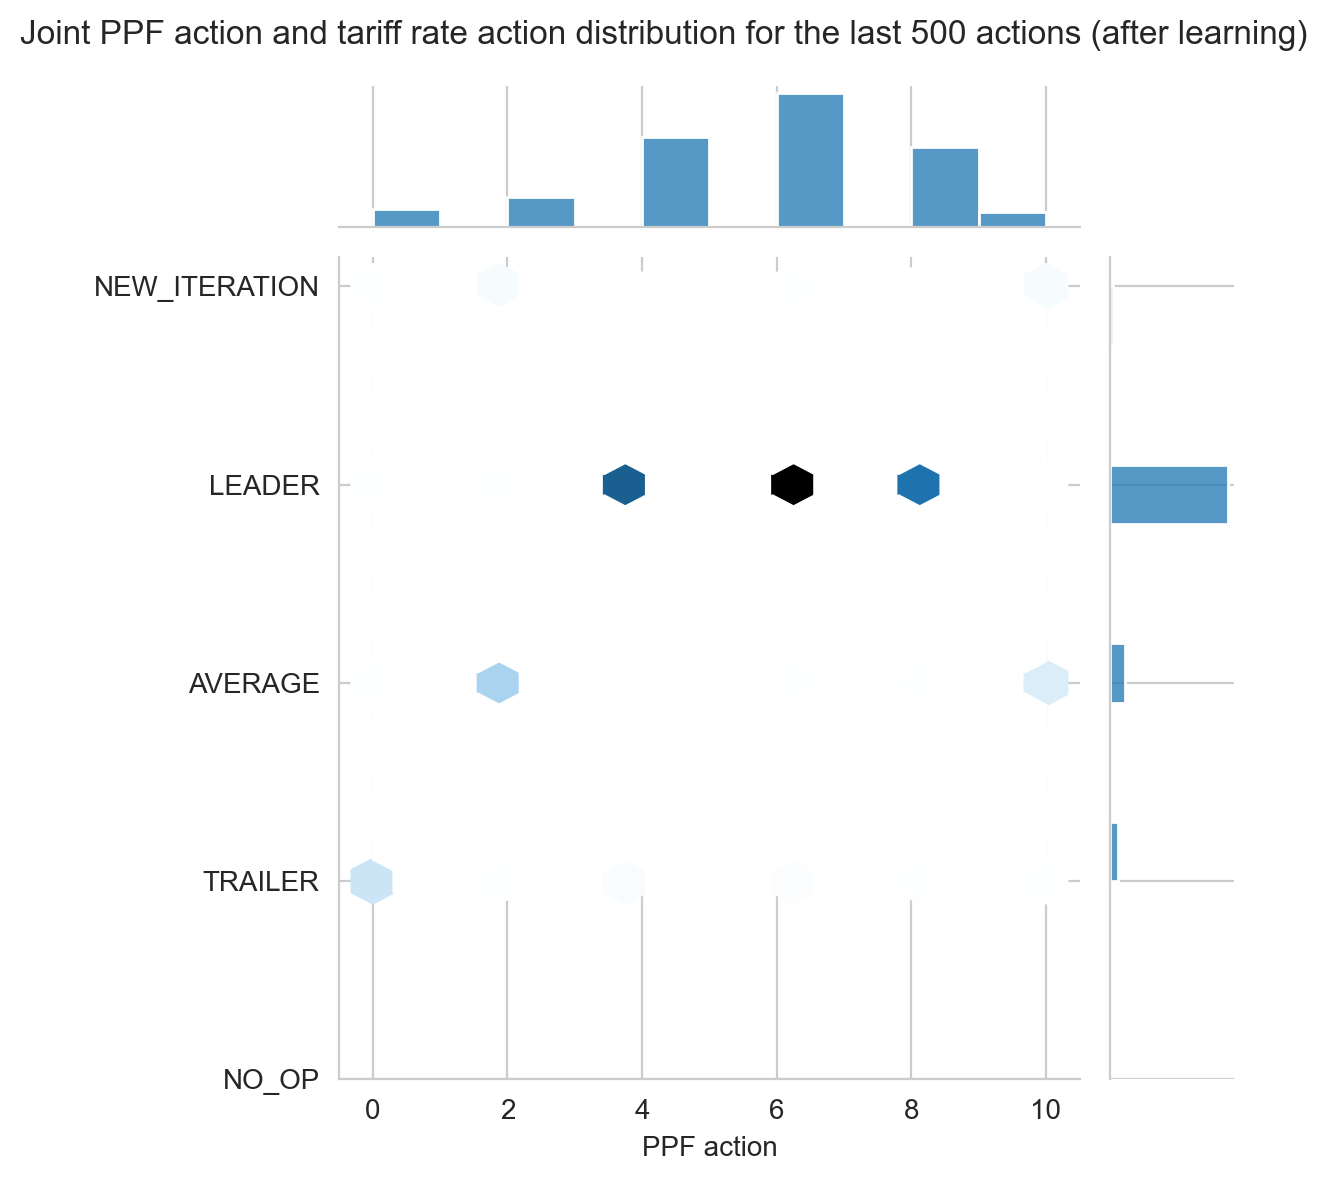

In [18]:
plot_joint_distribution(df_action)

In [19]:
def customer_share_plot(df_reward):
    customer_cols = [col for col in df_reward.columns if col.startswith("customer_")]
    df_customer_share = df_reward[customer_cols].rename(
        columns={col: col.replace("customer_", "").replace("_share", "") for col in customer_cols}
    )
    fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(21, 6))
    sns.boxplot(data=df_customer_share.iloc[:10000], ax=ax1)
    ax1.set_title("Customer share in the first 10000 timeslots")
    ax1.set_xlabel("Customer group")
    ax1.set_ylabel("Customer share")
    sns.boxplot(data=df_customer_share.iloc[-10000:], ax=ax2)
    ax2.set_title("Customer share in the last 10000 timeslots")
    ax2.set_xlabel("Customer group")
    ax2.set_ylabel("Customer share")
    fig.tight_layout()

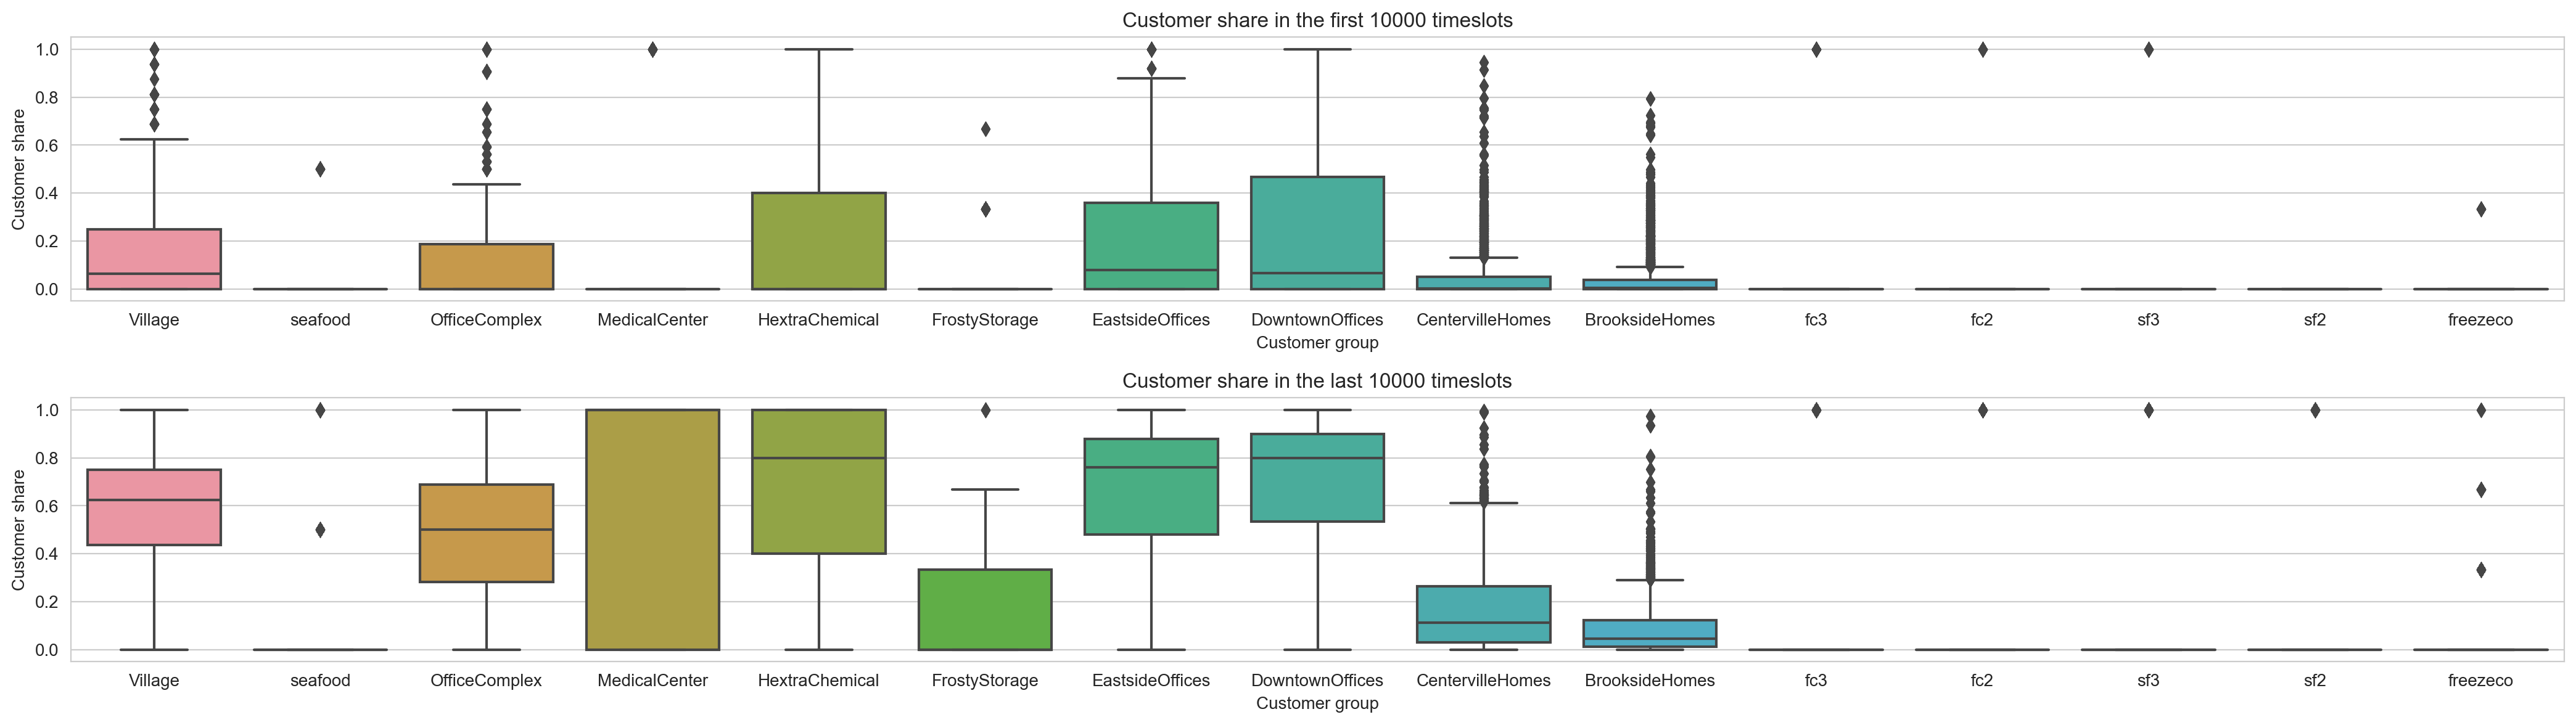

In [20]:
customer_share_plot(df_reward)

In [21]:
def plot_action_count_over_time(df_action, df_reward):
    fig, axs = plt.subplots(figsize=(21, 14), nrows=len(ACTION_VALUE_MAPPING), sharey=True)
    action_value_counts = (
        df_action[["gameId", "tariff_rate_action"]]
        .groupby(["gameId", "tariff_rate_action"], sort=False)
        .size()
        .unstack(fill_value=0)
        .reset_index(drop=True)
    )
    timeslots_per_game = df_reward.groupby("gameId", sort=False).count()["timeslot"].reset_index(drop=True)
    action_per_reward = np.ceil(len(df_reward) / len(df_action))
    action_value_fractions = action_value_counts.divide(timeslots_per_game, axis=0) * action_per_reward

    for i, action_value in enumerate(ACTION_VALUE_MAPPING.values()):
        ax = axs.flat[i]
        sns.lineplot(data=action_value_fractions[action_value], ax=ax)
        ax.set_title(
            f"Fraction of action={list(ACTION_VALUE_MAPPING.keys())[list(ACTION_VALUE_MAPPING.values()).index(action_value)]} over time for each game"
        )
        ax.set_xlabel("Game number")
        ax.set_ylabel("Action count fraction")
        ax.set_ylim((0, action_value_fractions.max().max()))
        ax.set_xticks(action_value_fractions.index)
        ax.margins(x=0)
    fig.tight_layout()

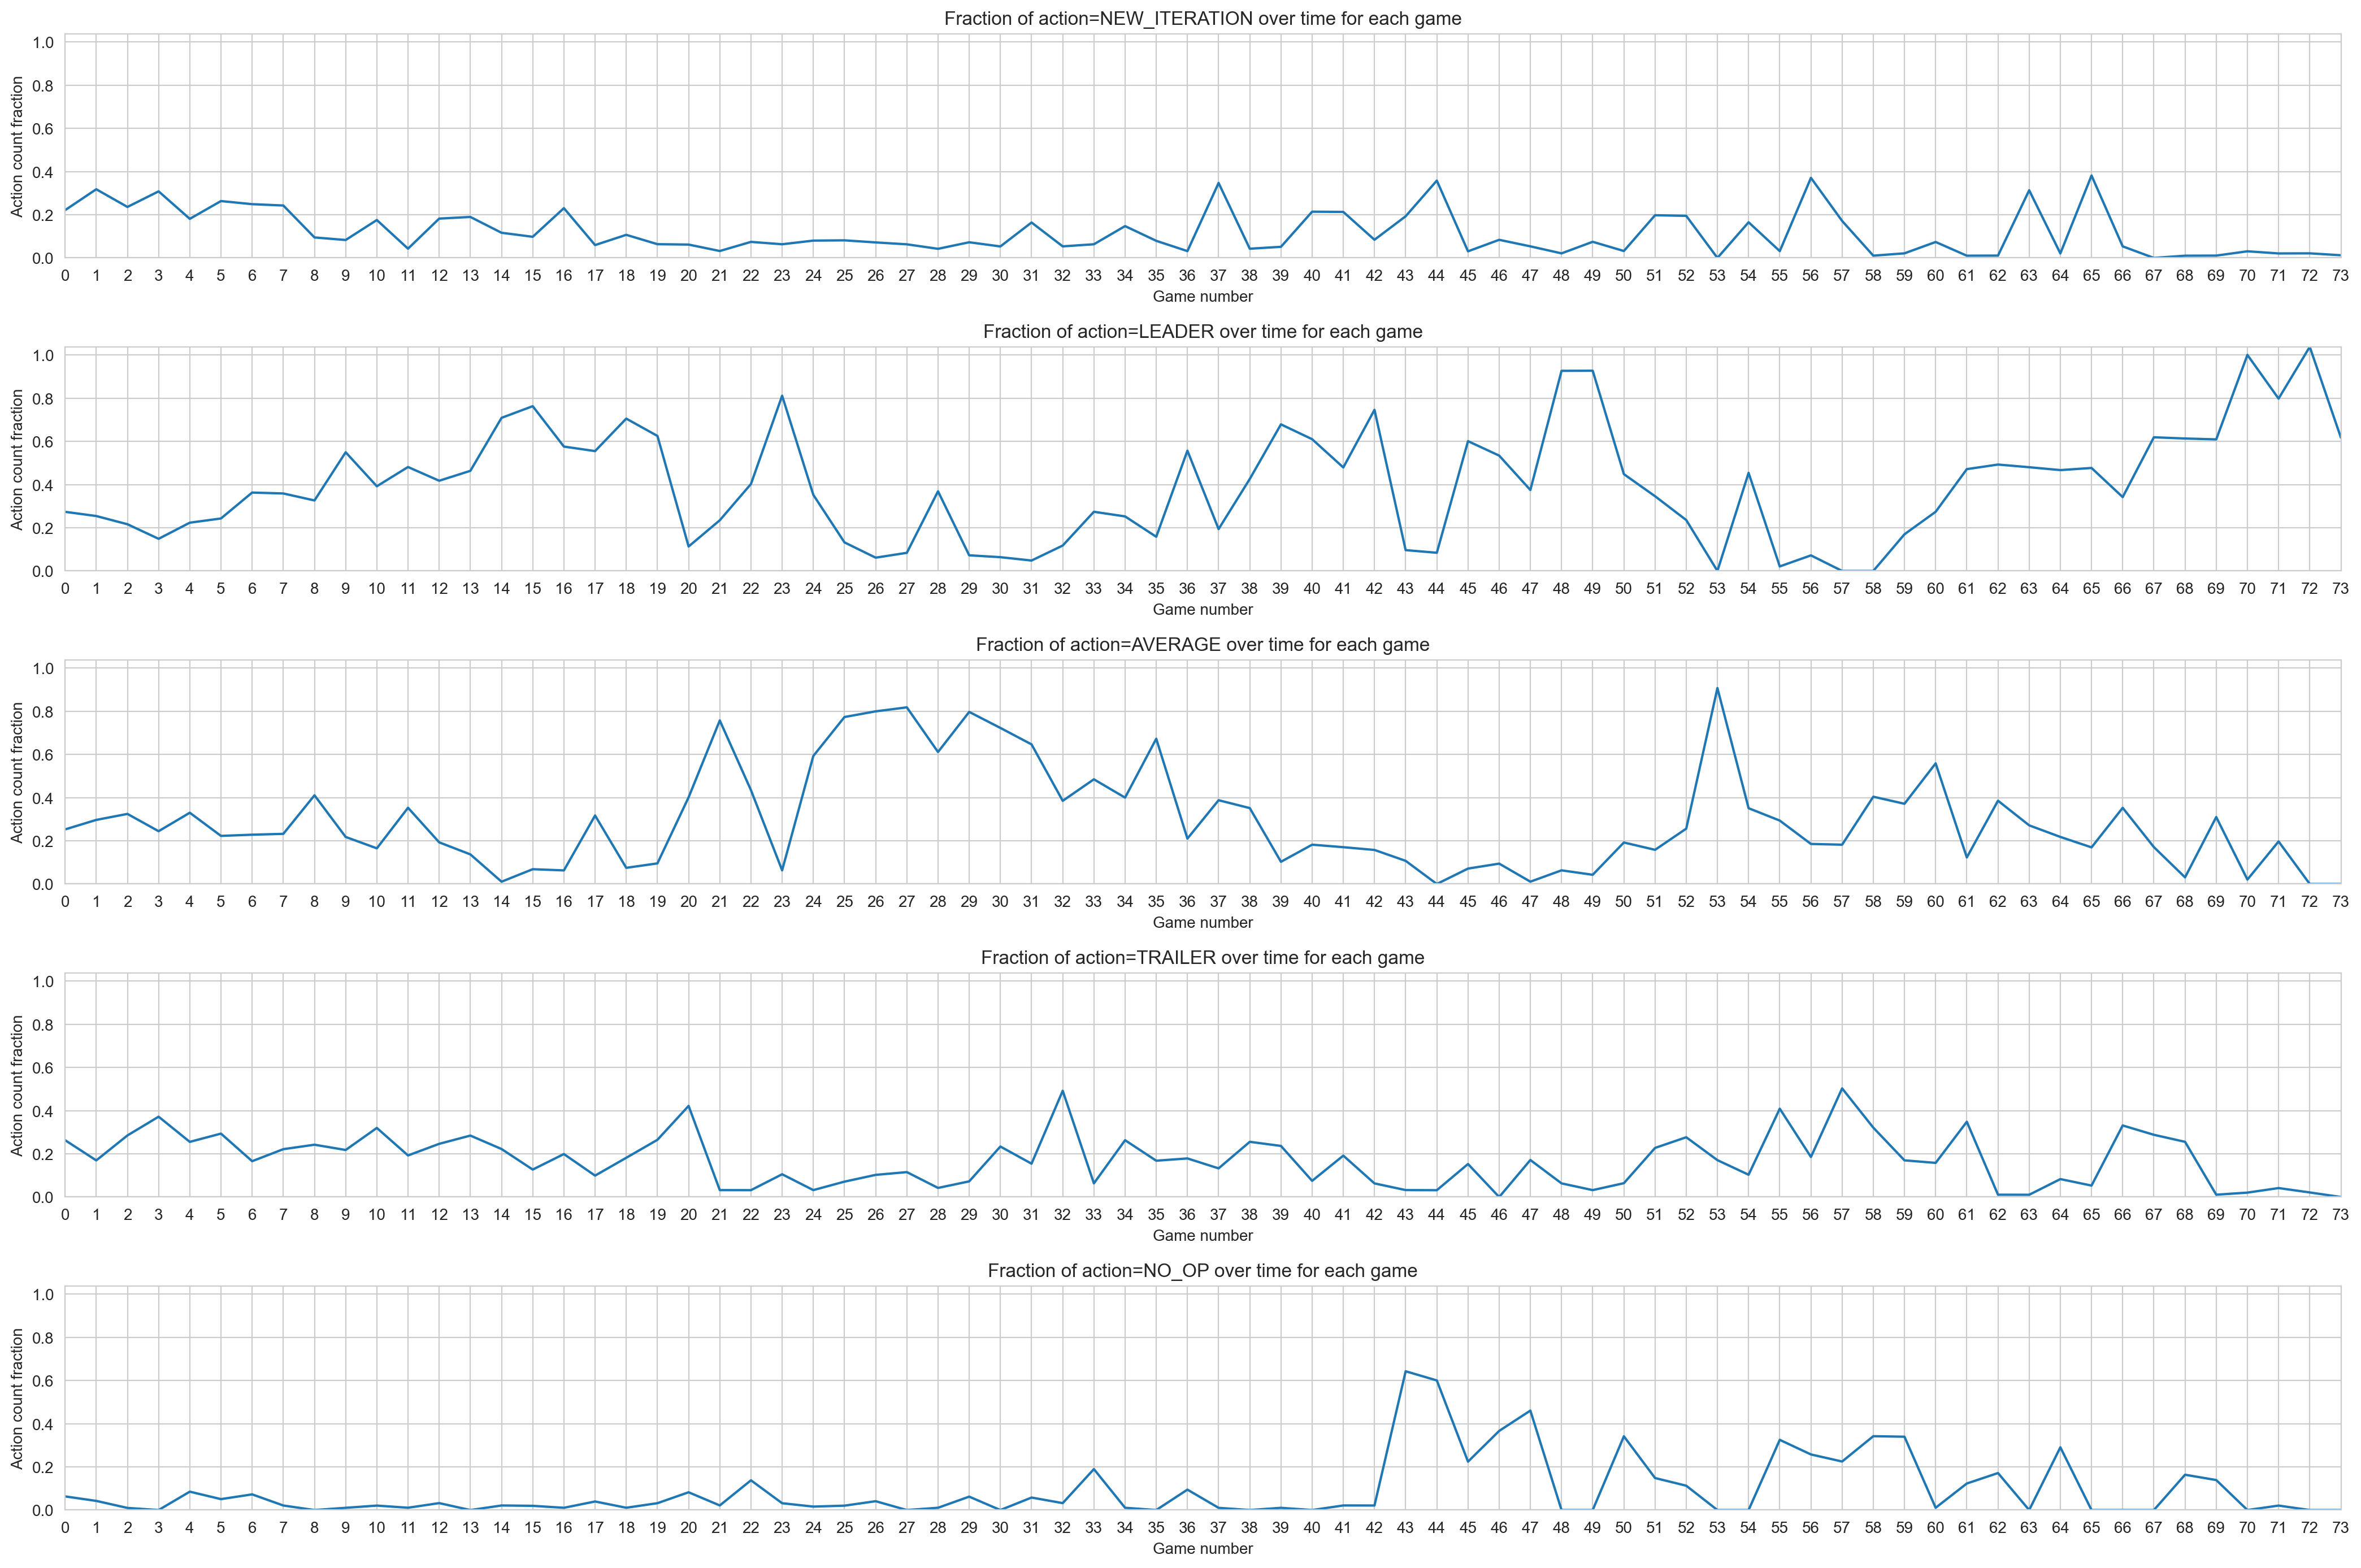

In [22]:
plot_action_count_over_time(df_action, df_reward)

In [23]:
def timestep_reg_plot(df_reward, column, window_size=168):
    fig, ax = plt.subplots(figsize=(16, 9))
    sns.lineplot(data=df_reward[column].rolling(window_size).mean(), label=f"Mean {column}", ax=ax)
    sns.regplot(
        x=df_reward.index,
        y=column,
        data=df_reward[[column]].rolling(window_size).mean(),
        scatter=False,
        marker=".",
        ax=ax,
        label="OLS fit",
    )
    ax.vlines(
        df_reward[df_reward["gameId"] != df_reward["gameId"].shift()].index + window_size,
        0,
        1,
        transform=ax.get_xaxis_transform(),
        colors="r",
        alpha=0.2,
        label="New game",
    )
    ax.set_xlabel("Timeslot")
    ax.set_ylabel(column)
    ax.set_title(f"Rolling mean {column} with window size {window_size}")
    ax.legend()

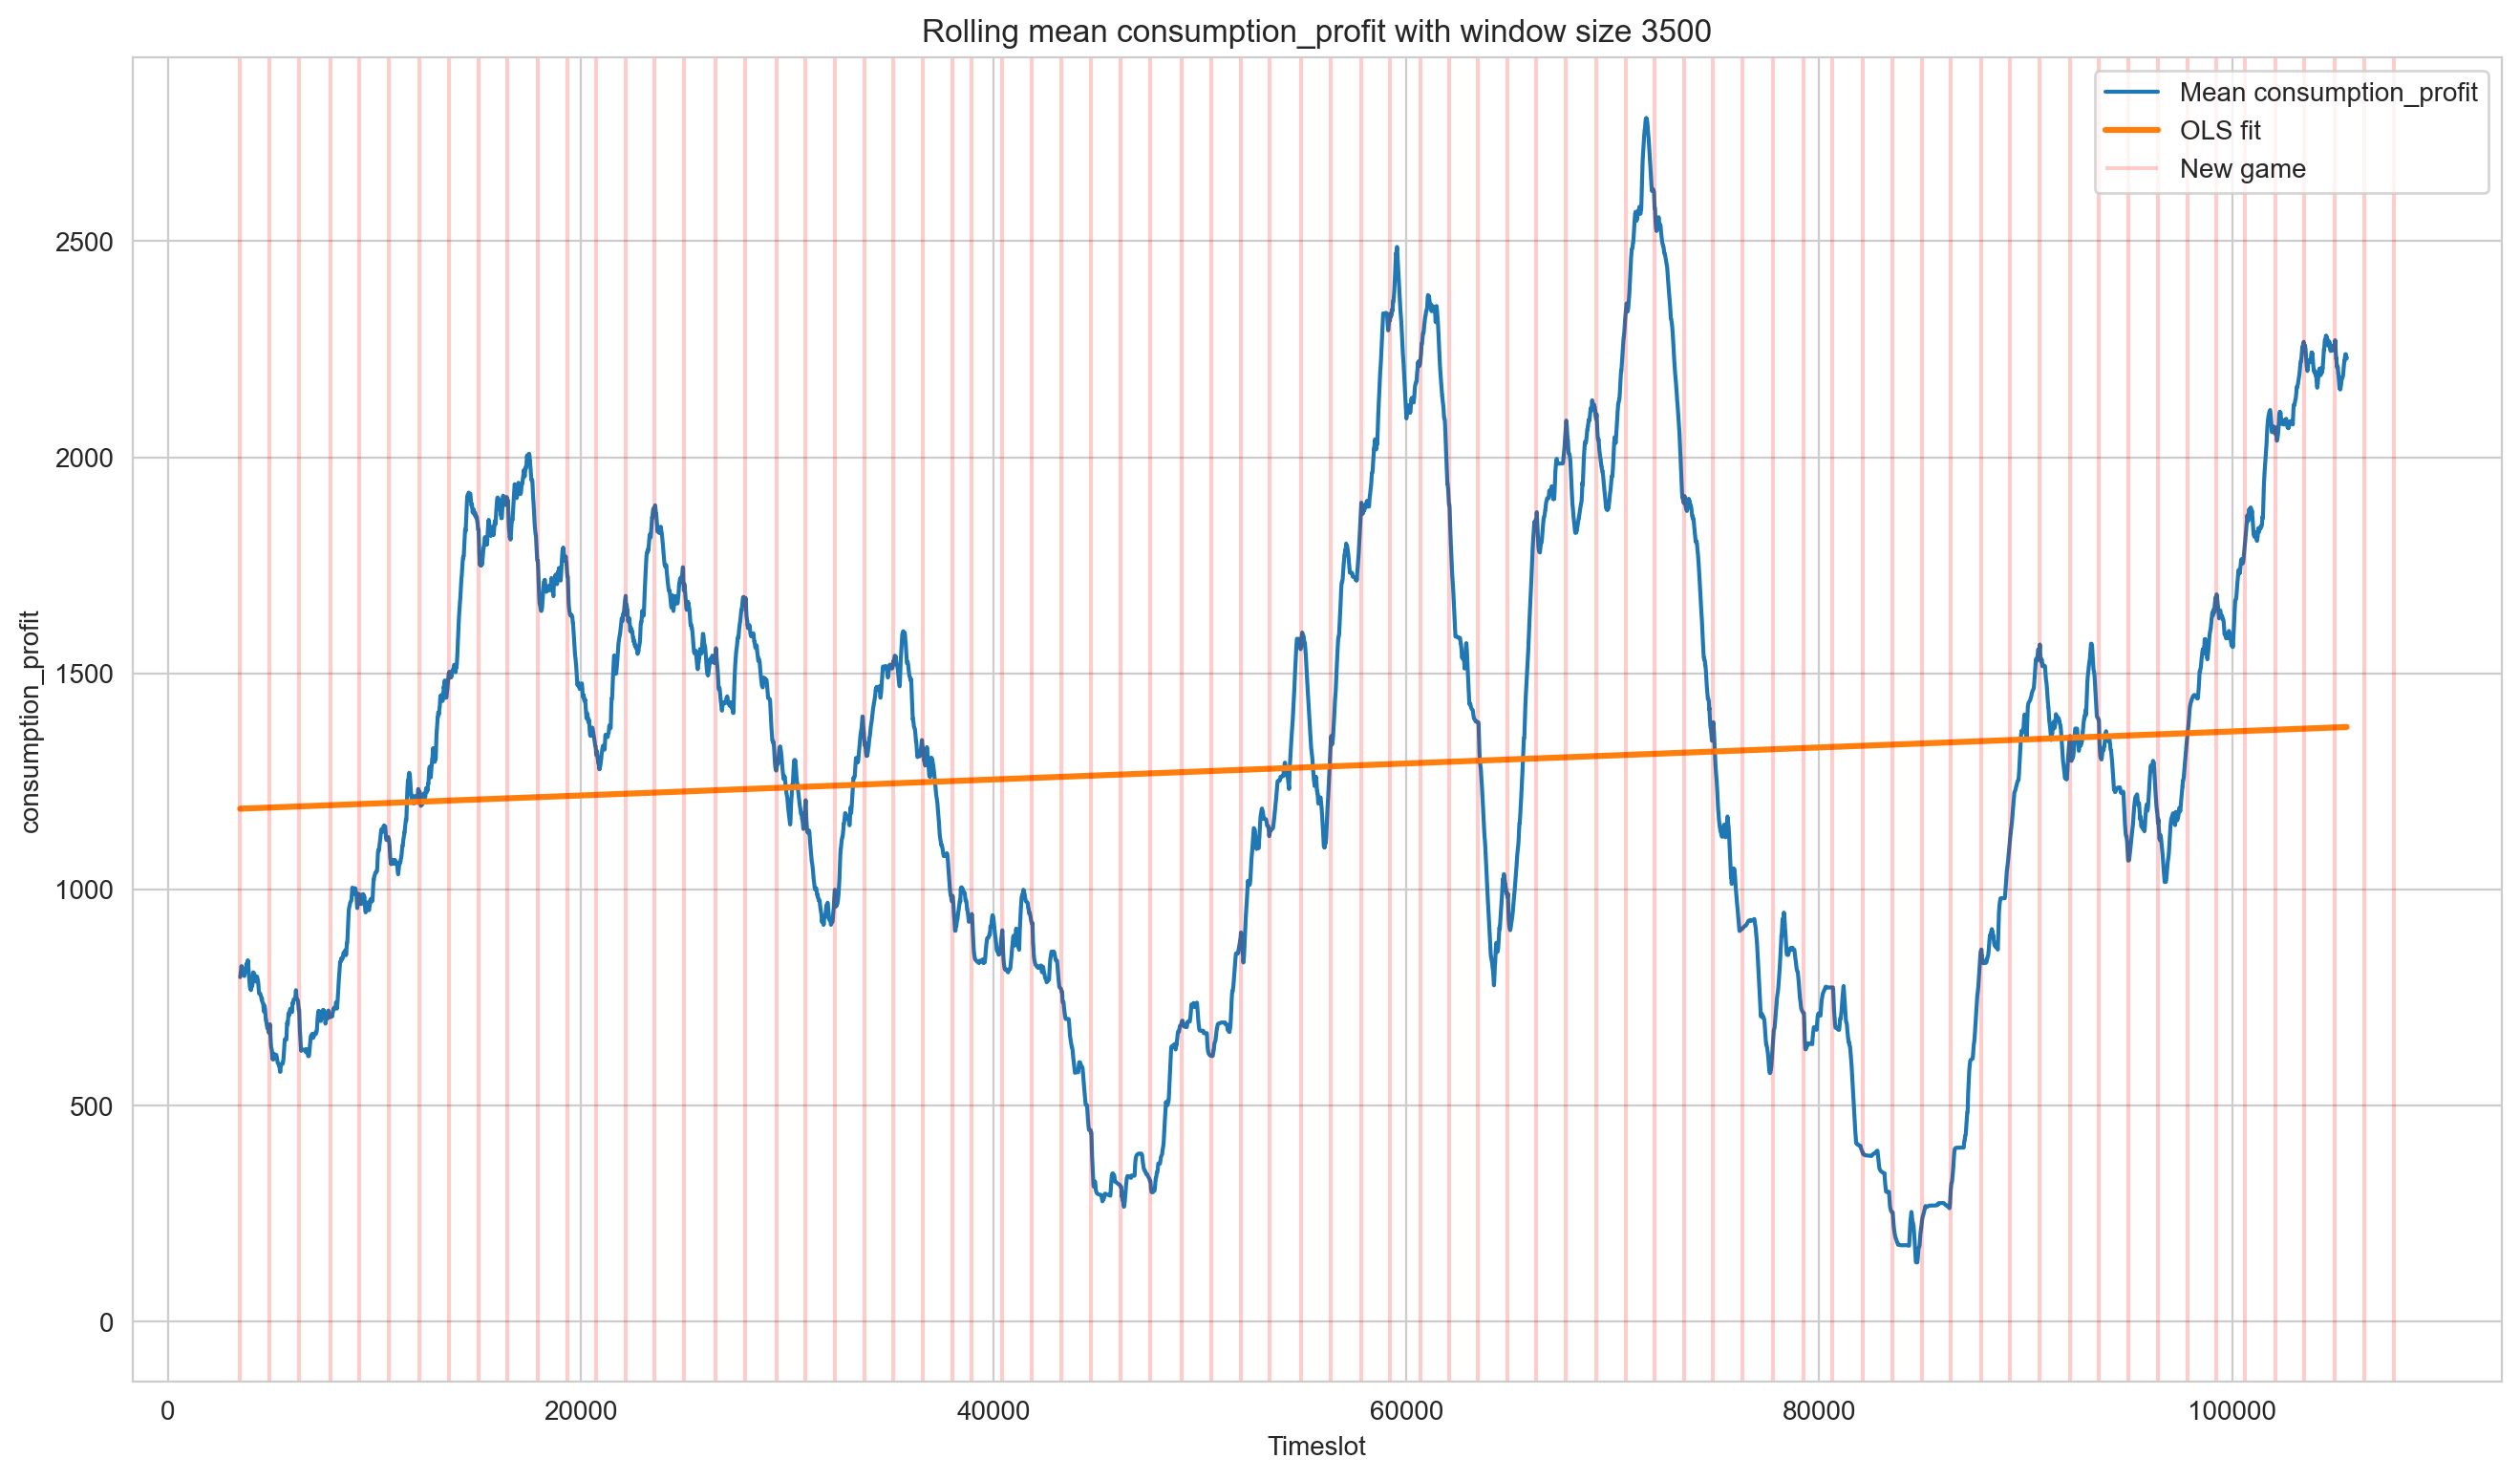

In [24]:
timestep_reg_plot(df_reward, "consumption_profit", window_size=3500)

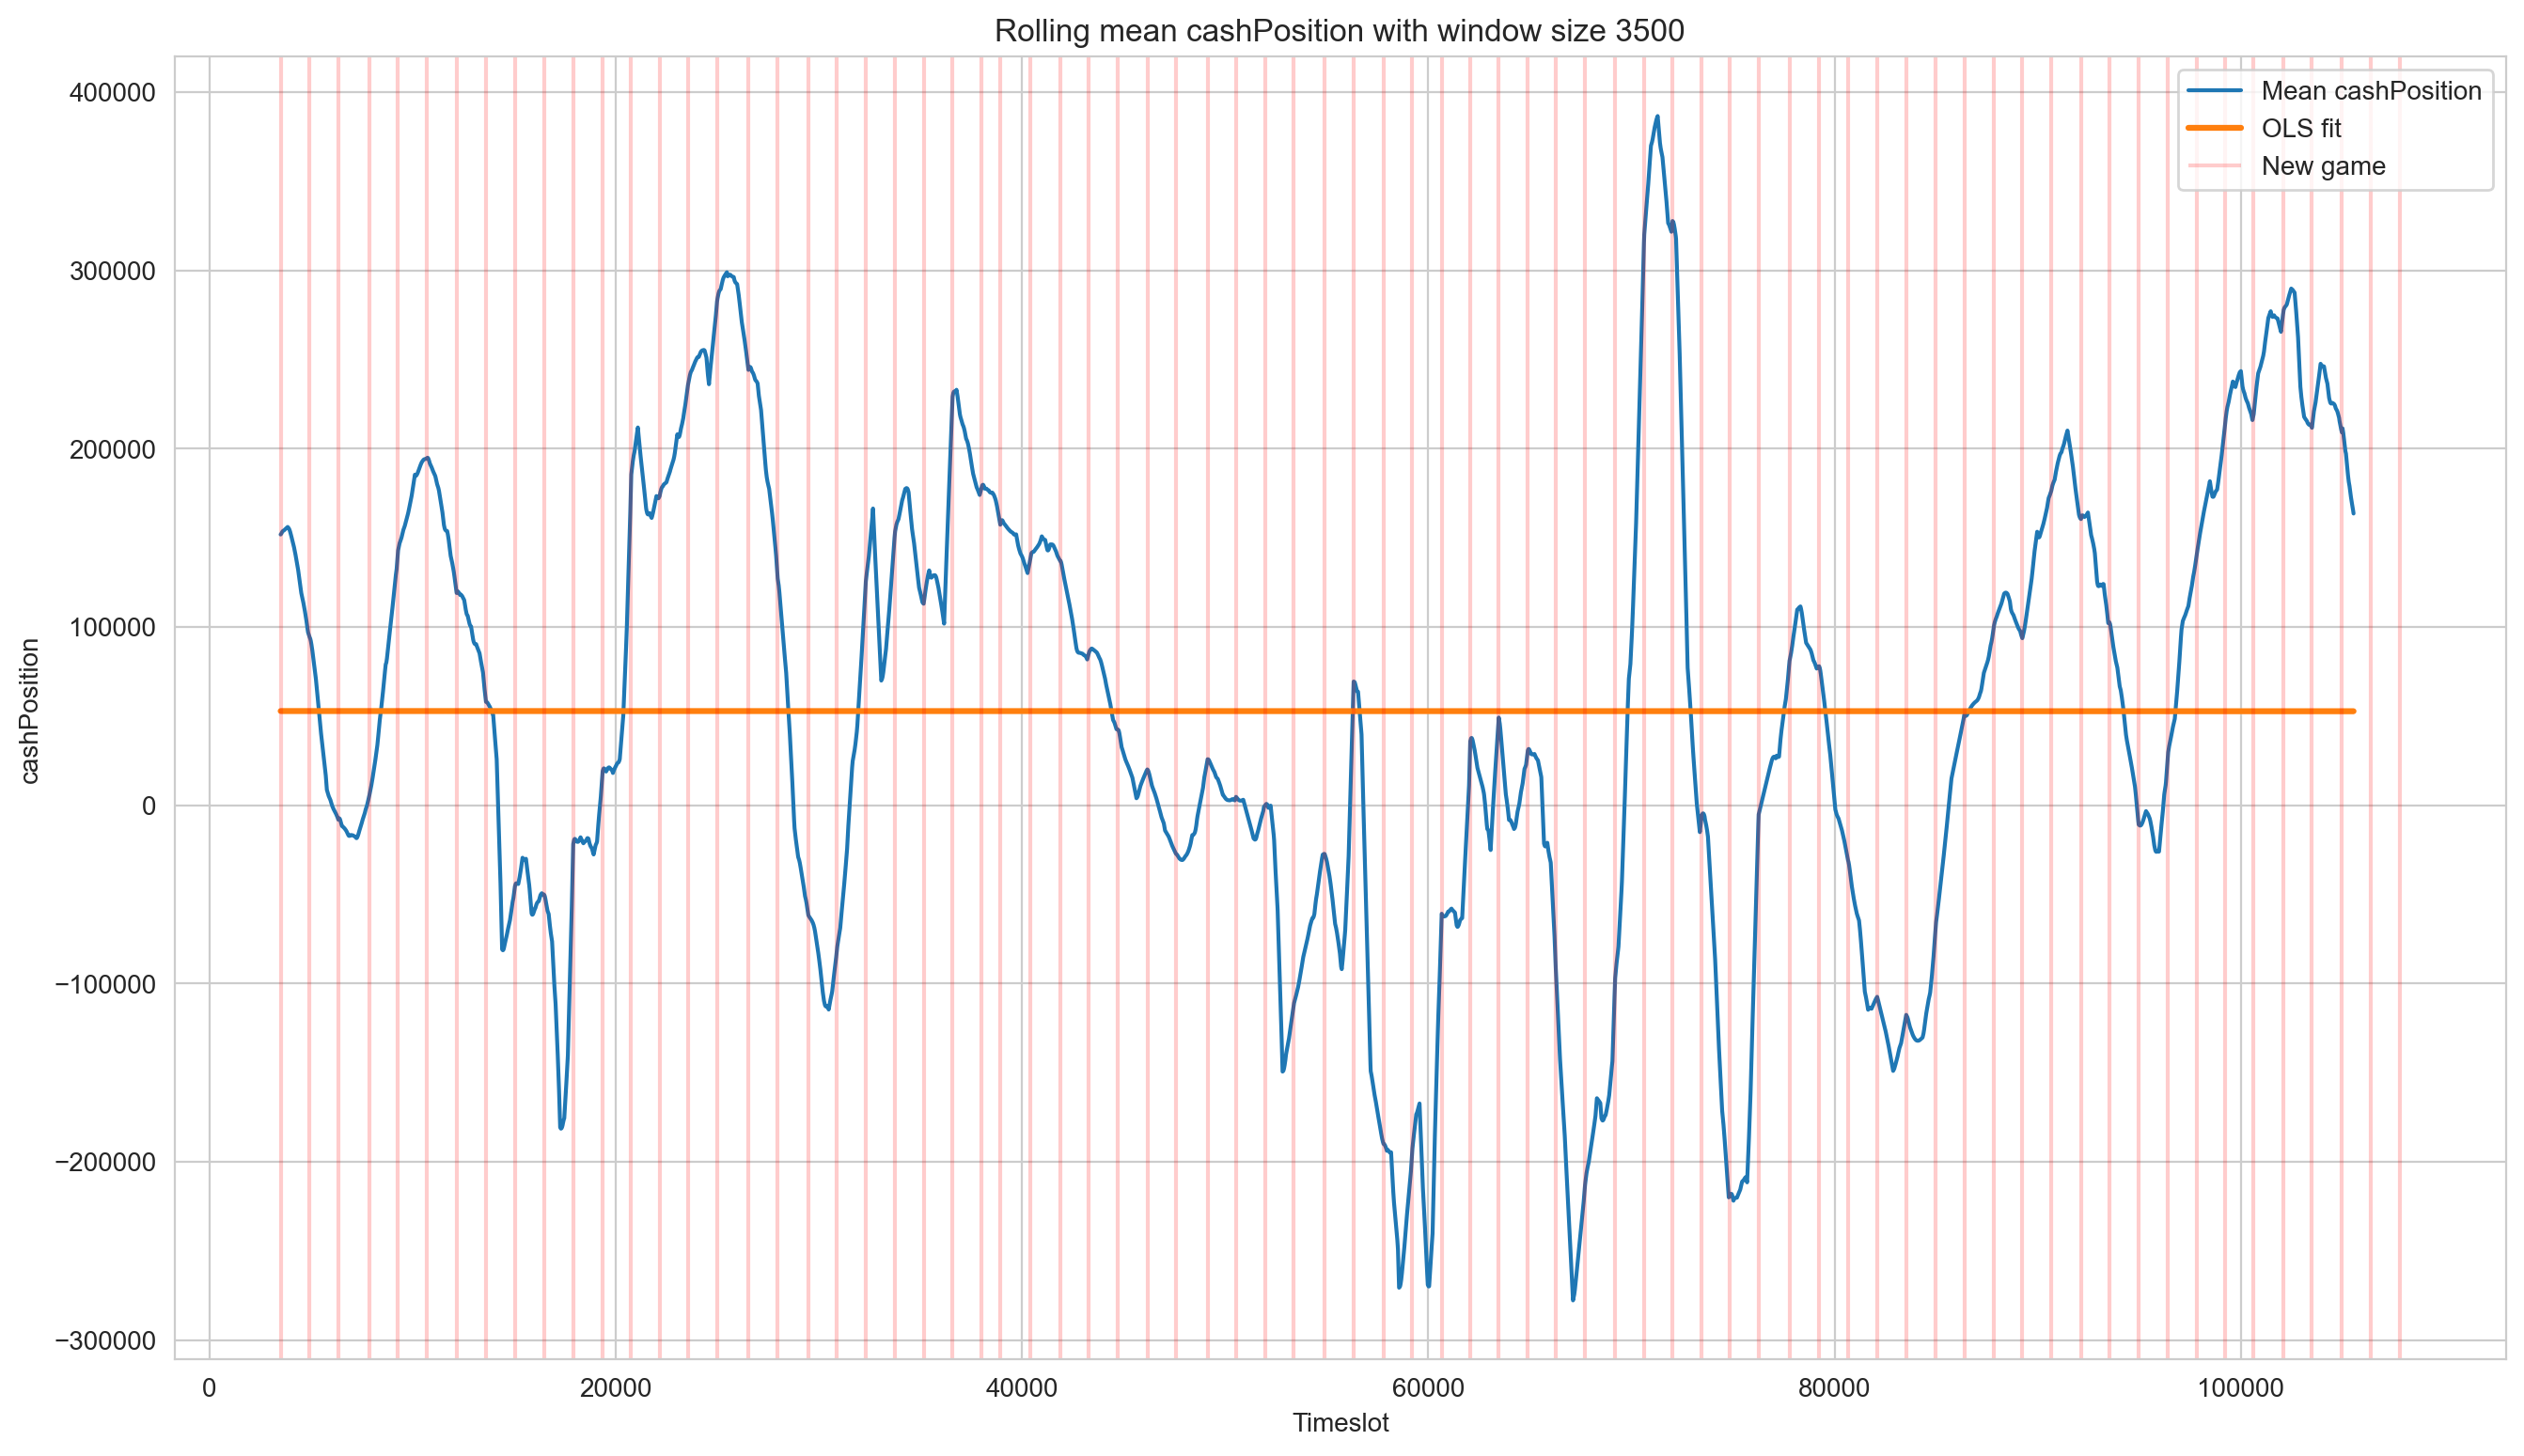

In [25]:
timestep_reg_plot(df_reward, "cashPosition", window_size=3500)

In [26]:
def plot_final_cash_position(df_reward):
    fig, ax = plt.subplots(figsize=(16, 9))
    df_final_timeslot = df_reward[df_reward["gameId"].shift(-1) != df_reward["gameId"]].reset_index()
    df_final_timeslot["cashPosition"] = (
        df_final_timeslot["cashPosition"] / df_final_timeslot["timeslot"].max() * df_final_timeslot["timeslot"]
    )
    sns.lineplot(
        x=df_final_timeslot.index, y="cashPosition", data=df_final_timeslot, label="Final cash position", ax=ax
    )
    sns.regplot(
        x=df_final_timeslot.index,
        y="cashPosition",
        data=df_final_timeslot,
        scatter=False,
        marker=".",
        ax=ax,
        label="OLS fit",
    )
    ax.set_xlabel("Game")
    ax.set_ylabel("Cash position")
    ax.set_title(f"Final cash position per game (adjusted for game length)")
    ax.set_xticks(df_final_timeslot.index)
    ax.margins(x=0)
    ax.legend()

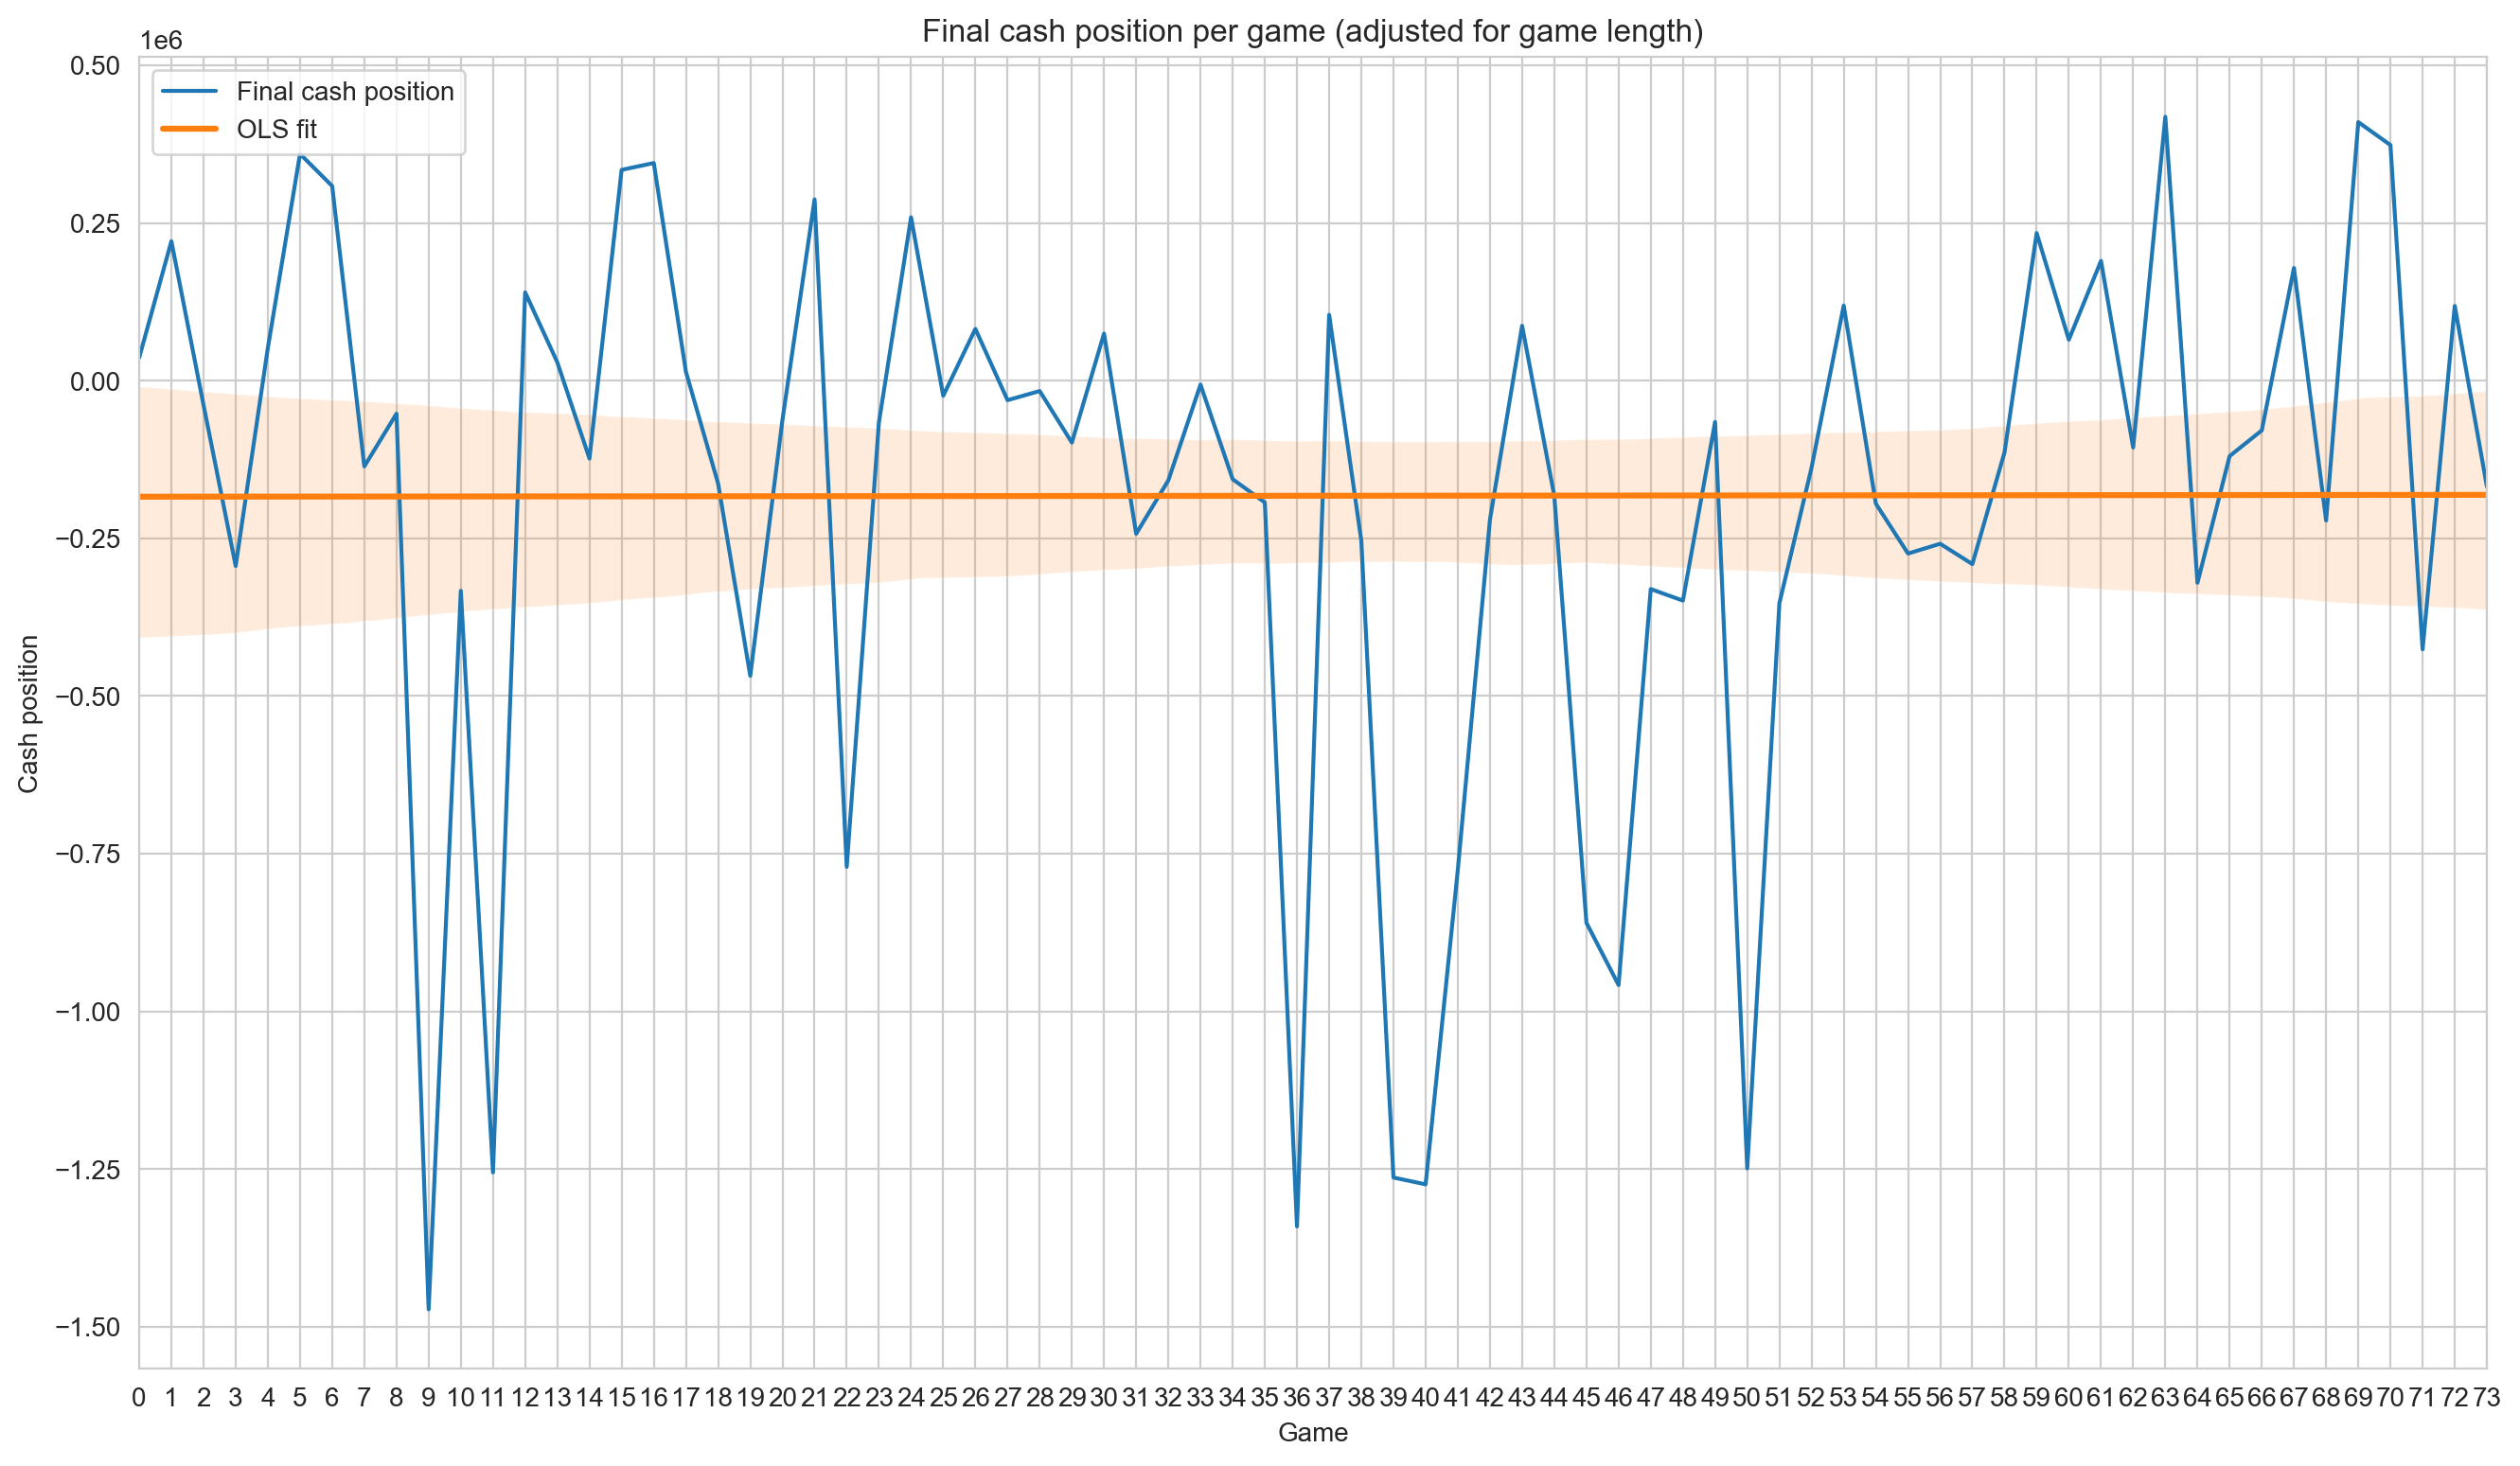

In [27]:
plot_final_cash_position(df_reward)

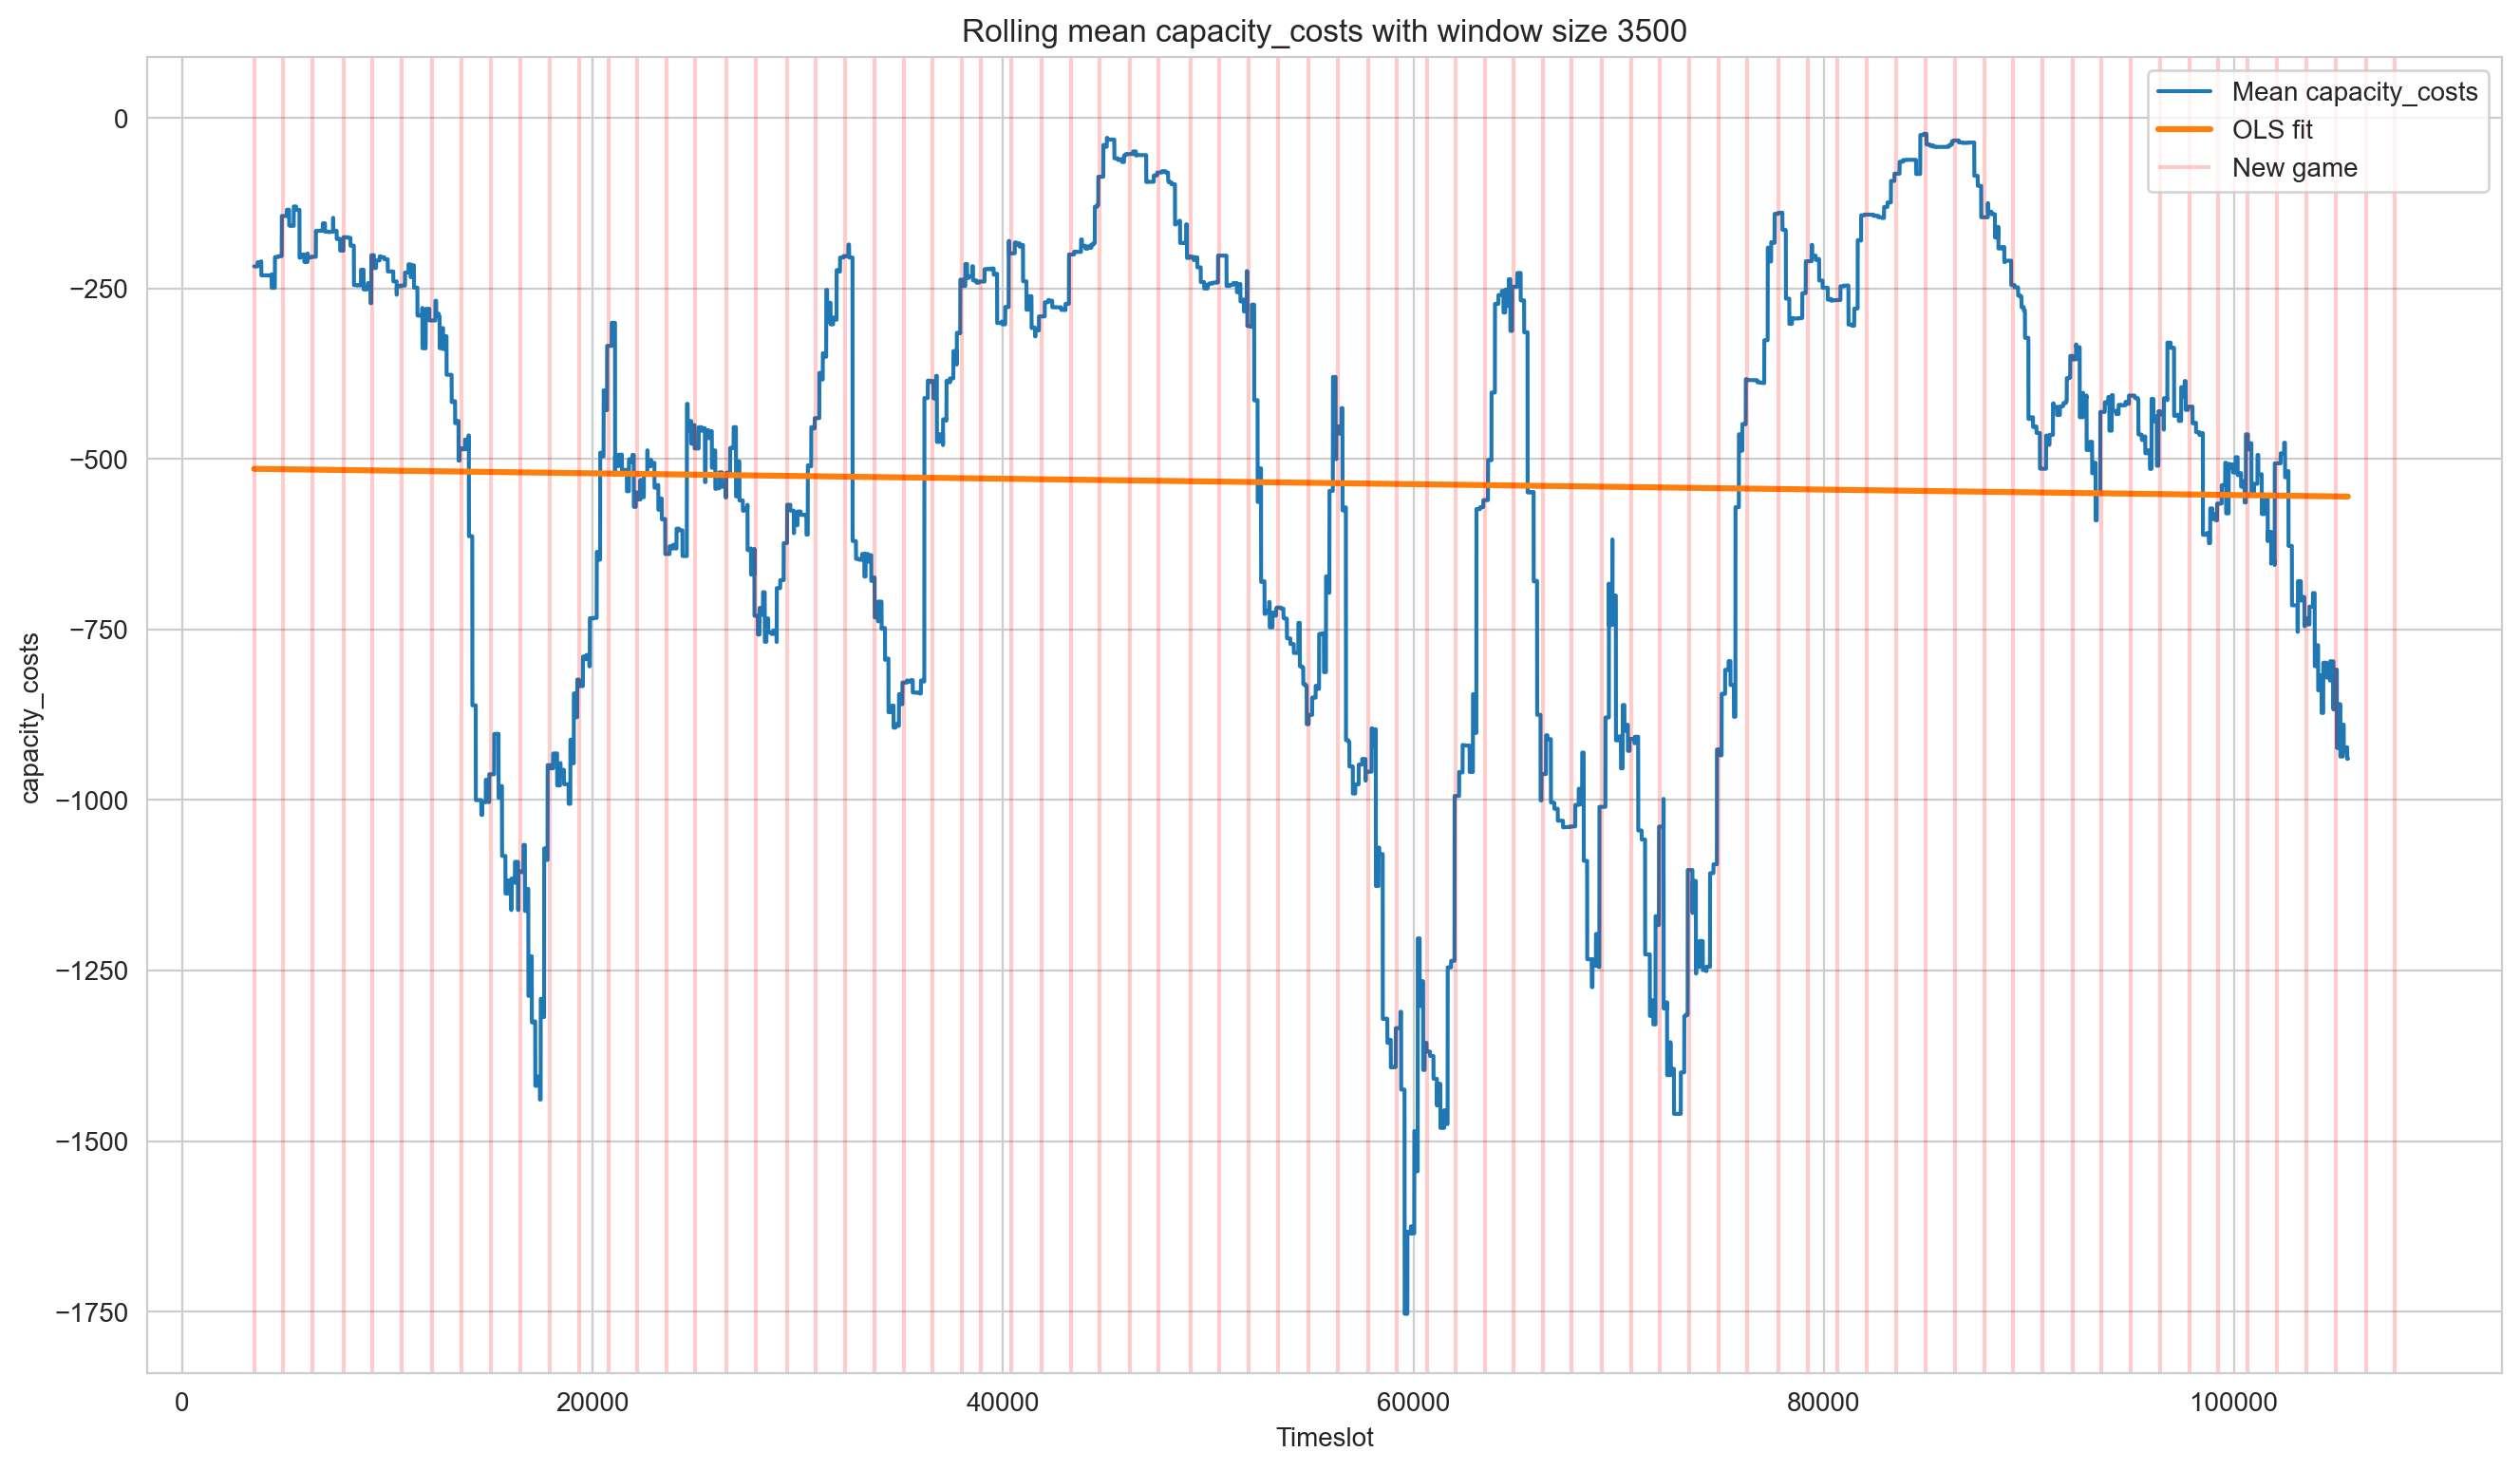

In [28]:
timestep_reg_plot(df_reward, "capacity_costs", window_size=3500)

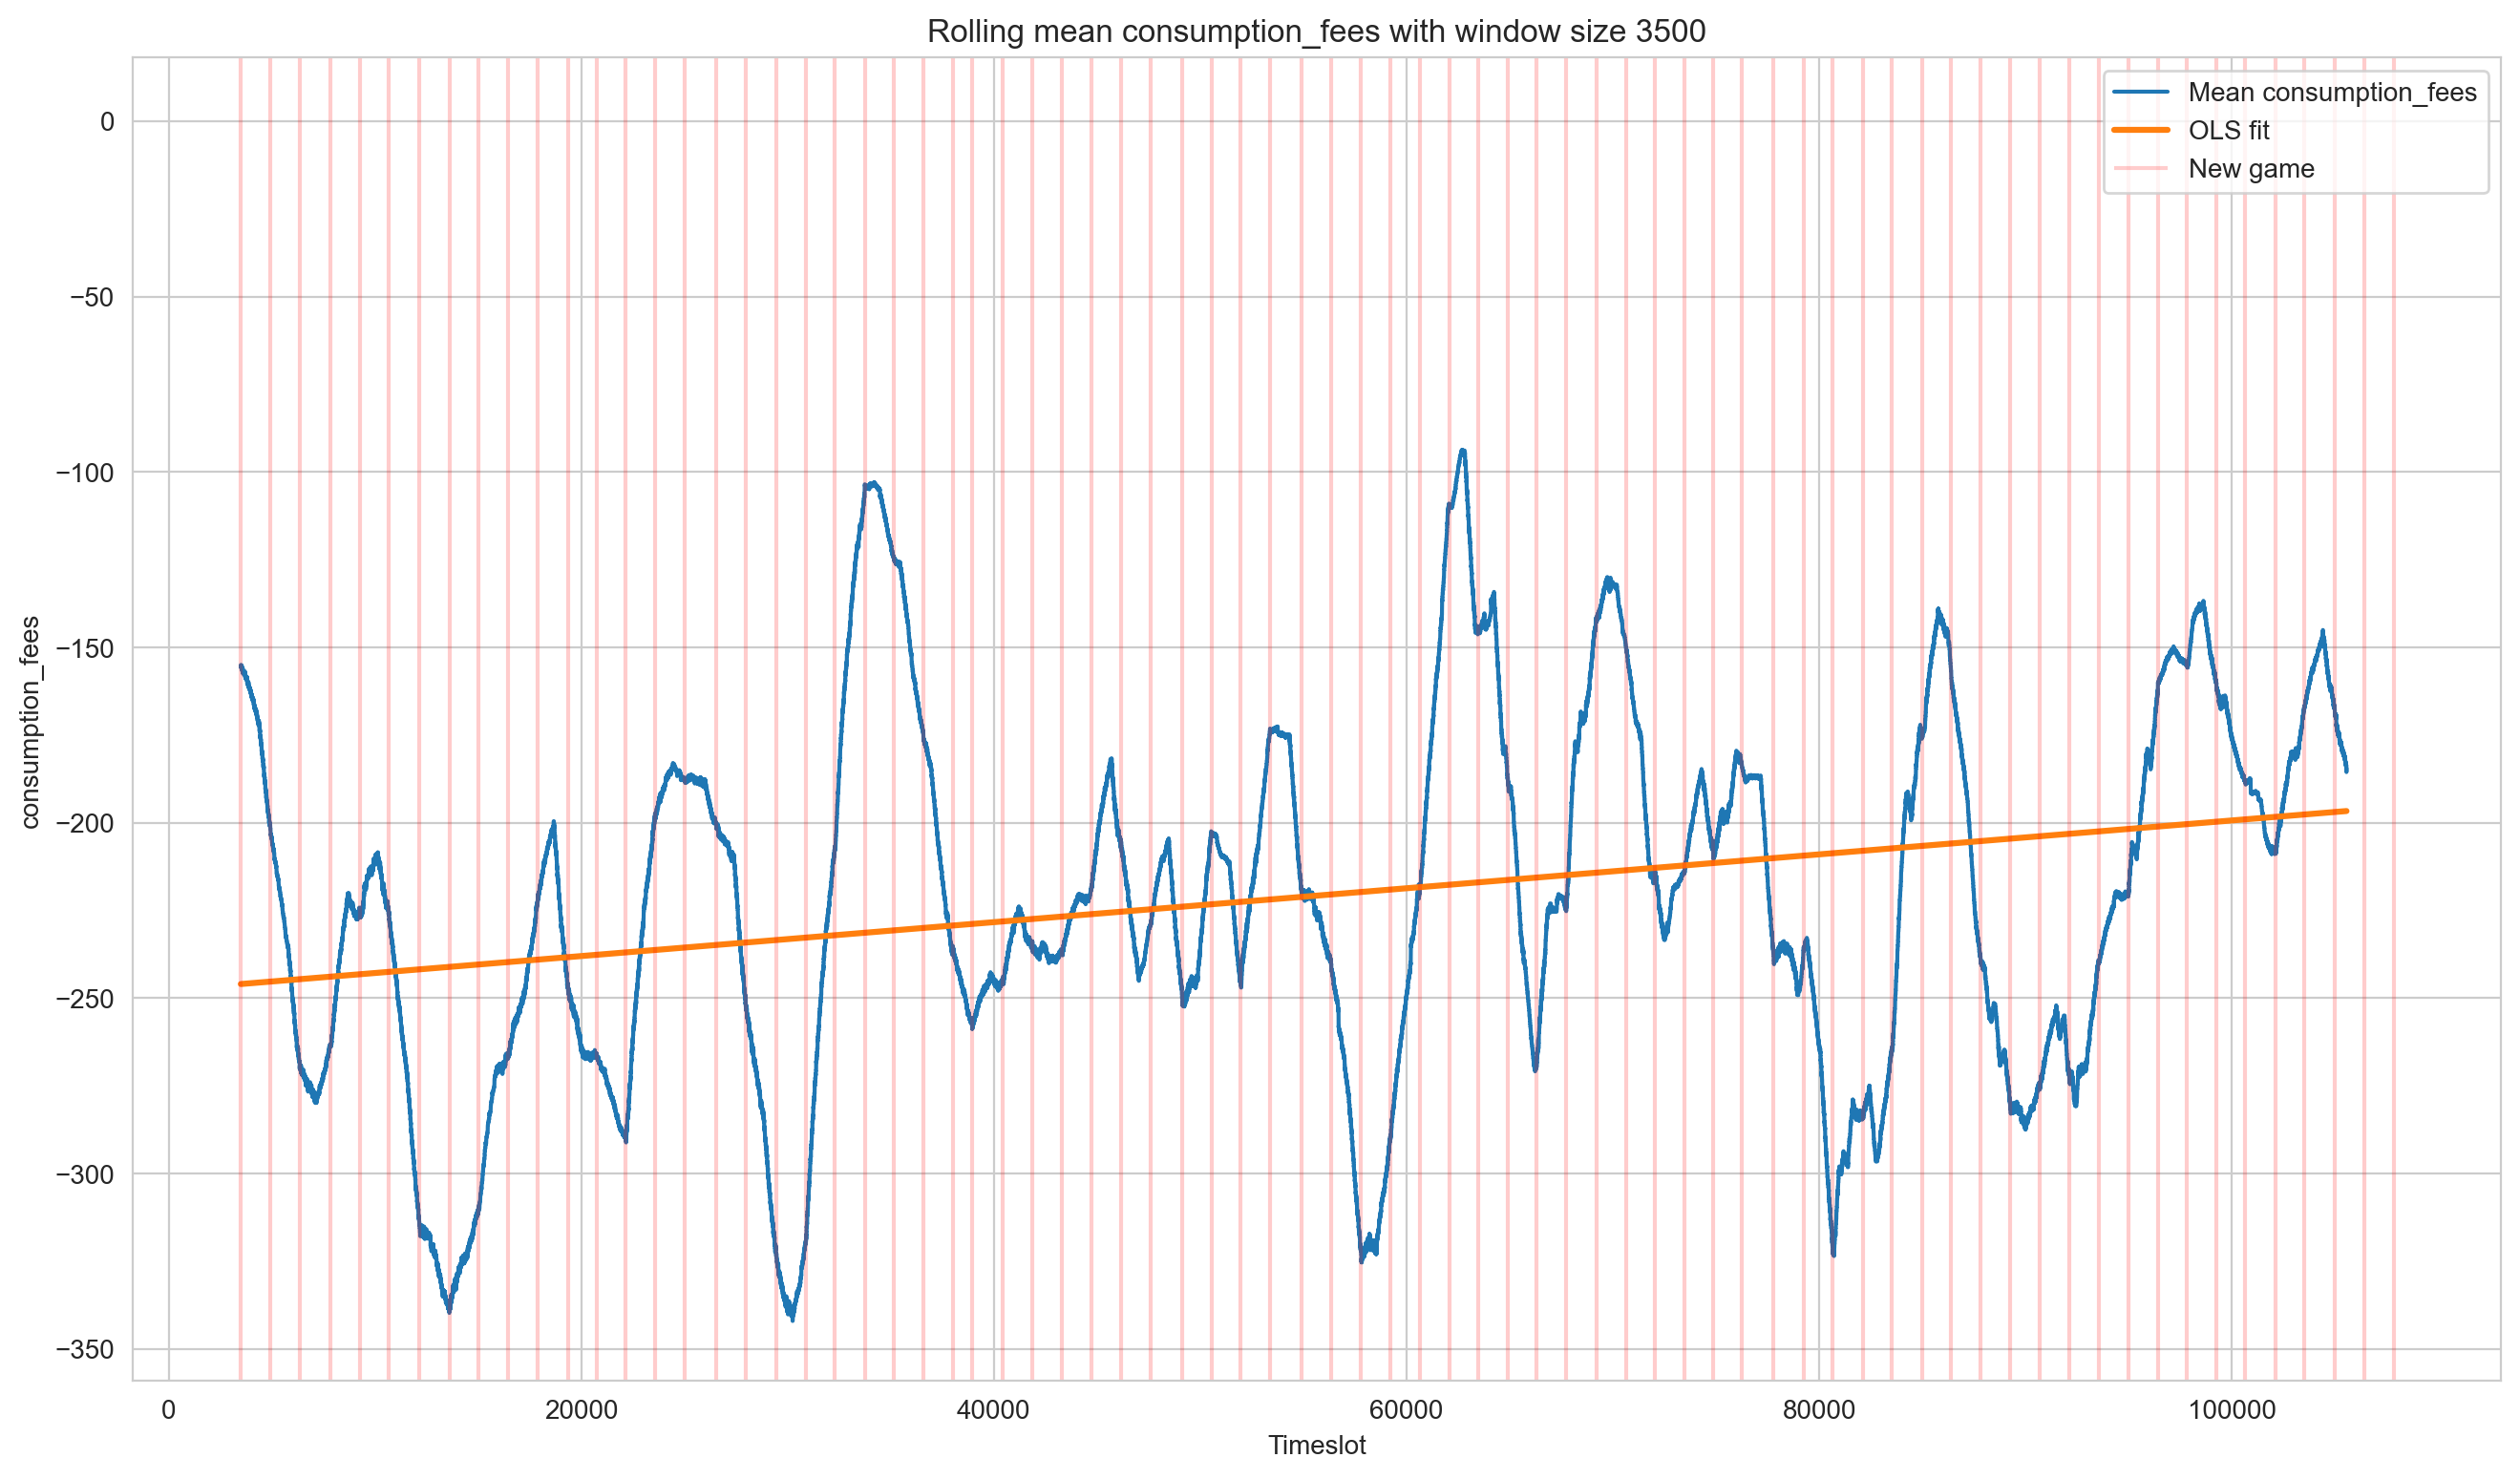

In [29]:
timestep_reg_plot(df_reward, "consumption_fees", window_size=3500)

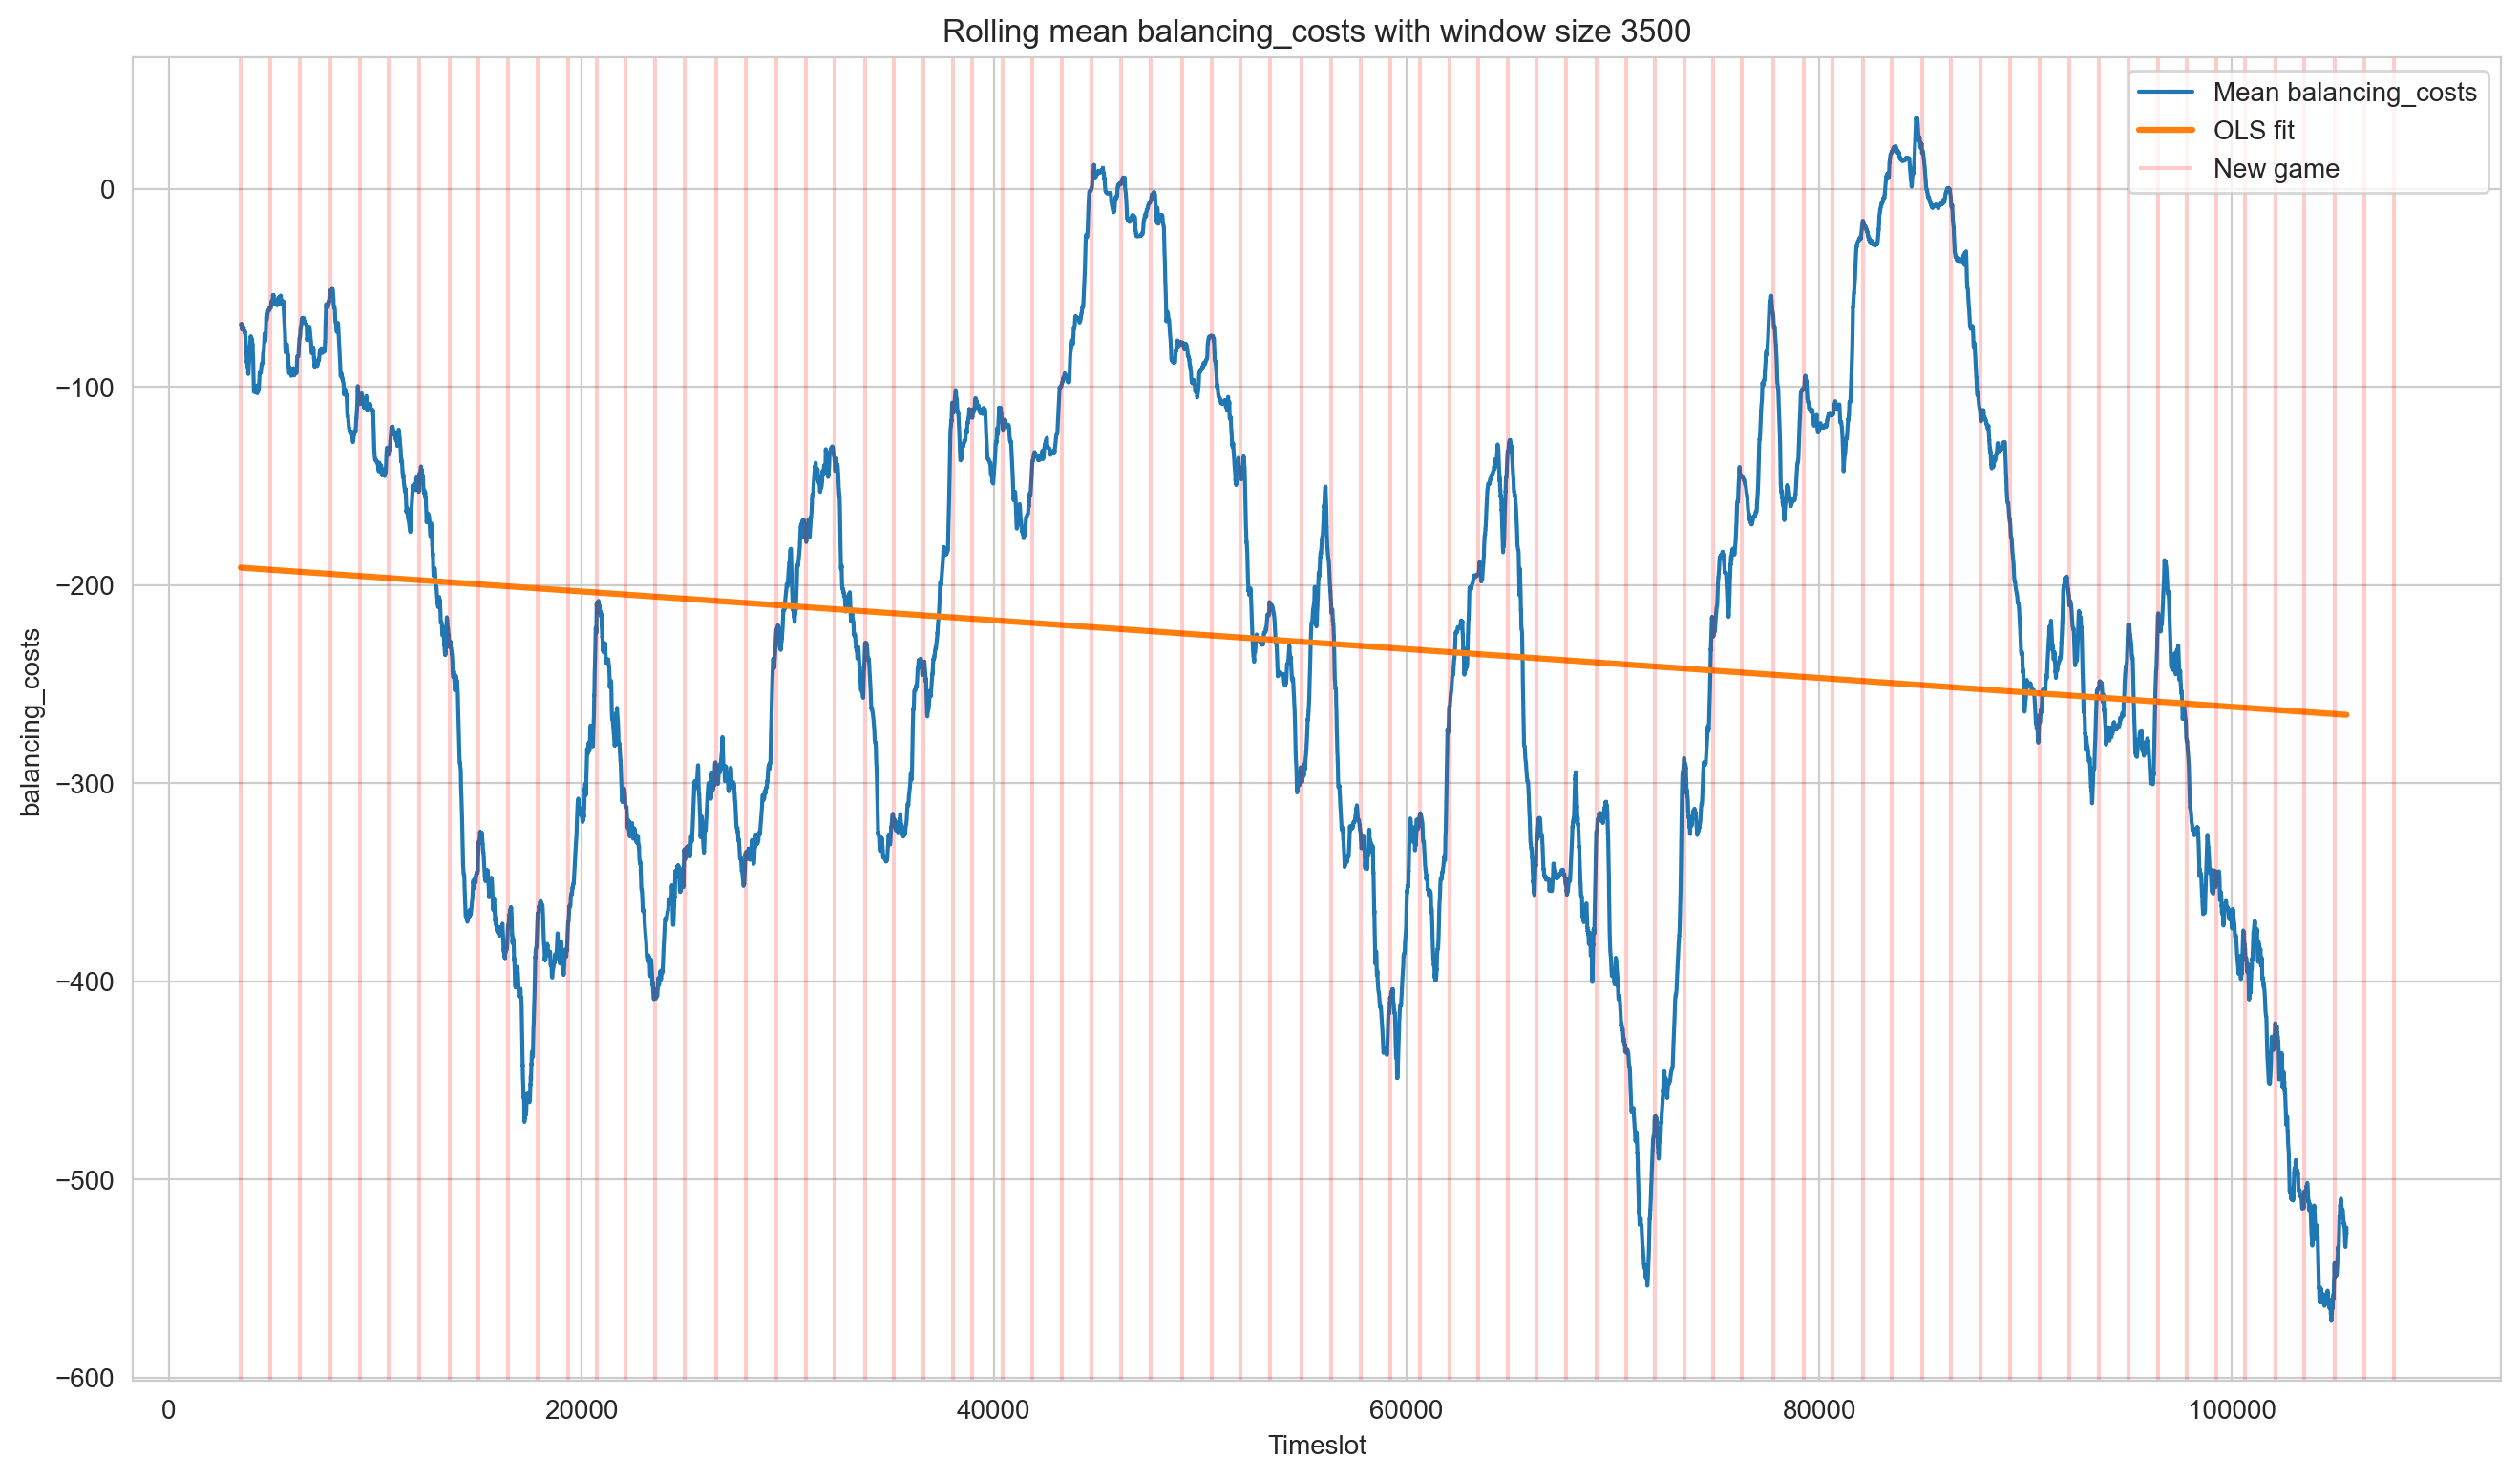

In [30]:
timestep_reg_plot(df_reward, "balancing_costs", window_size=3500)

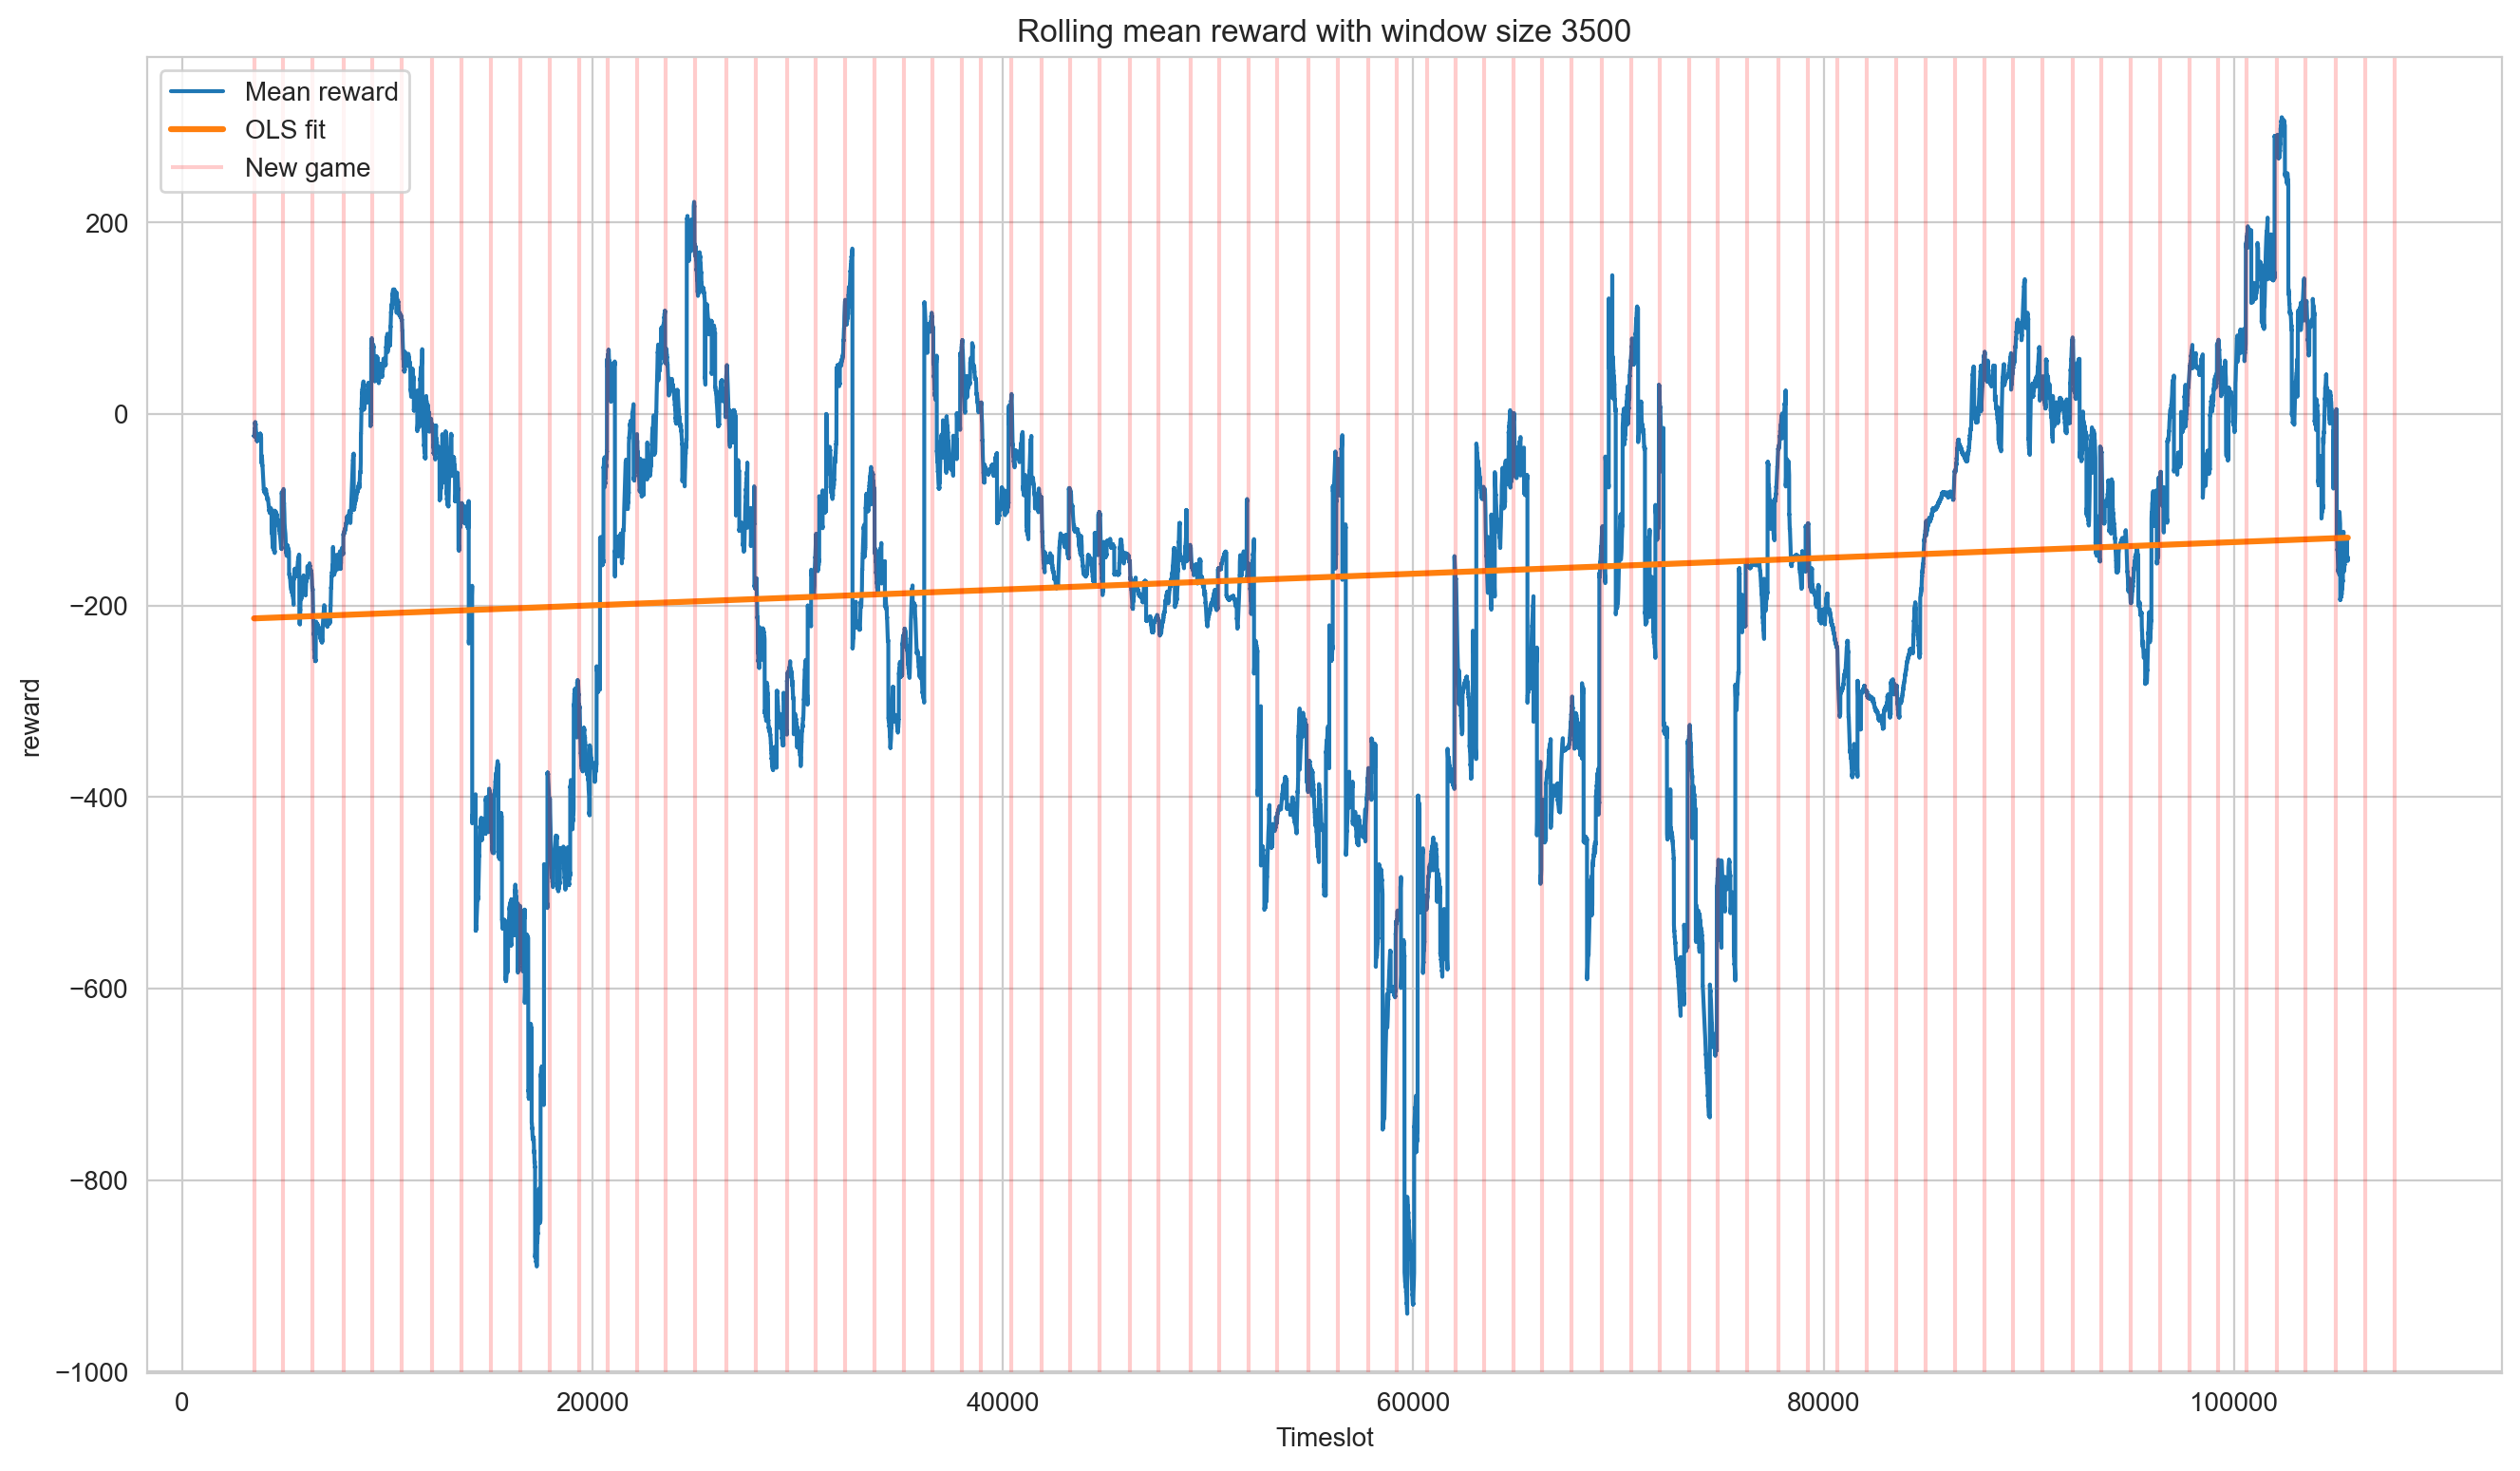

In [31]:
timestep_reg_plot(df_reward, "reward", window_size=3500)

In [32]:
def plot_mean_episode_reward_reg(df_reward, df_action, window_size=10):
    fig, ax = plt.subplots(figsize=(21, 11))
    df_mean_episode_reward = df_reward.groupby("episode_id", sort=False).mean().reset_index()
    sns.lineplot(
        x=df_mean_episode_reward.index,
        y="reward",
        data=df_mean_episode_reward[["reward"]].rolling(window_size).mean(),
        label="Mean episode reward",
        ax=ax,
    )
    sns.regplot(
        x=df_mean_episode_reward.index,
        y="reward",
        data=df_mean_episode_reward[["reward"]].rolling(window_size).mean(),
        scatter=False,
        marker=".",
        ax=ax,
        label="OLS fit",
    )
    df_episode_game_id = df_reward.groupby("episode_id", sort=False)["gameId"].first().reset_index()
    ax.vlines(
        df_episode_game_id[df_episode_game_id["gameId"].shift() != df_episode_game_id["gameId"]].index + window_size,
        0,
        1,
        transform=ax.get_xaxis_transform(),
        colors="r",
        alpha=0.3,
        label="New game",
    )
    ax.set_xlabel("Episode")
    ax.set_ylabel("Aggregated reward")
    ax.legend()
    ax.set_title(
        f"Mean episode reward (N_EPISODES: {df_reward['episode_id'].nunique()}, N_TIMESTEPS: {len(df_action)})"
    )
    ax.margins(x=0)

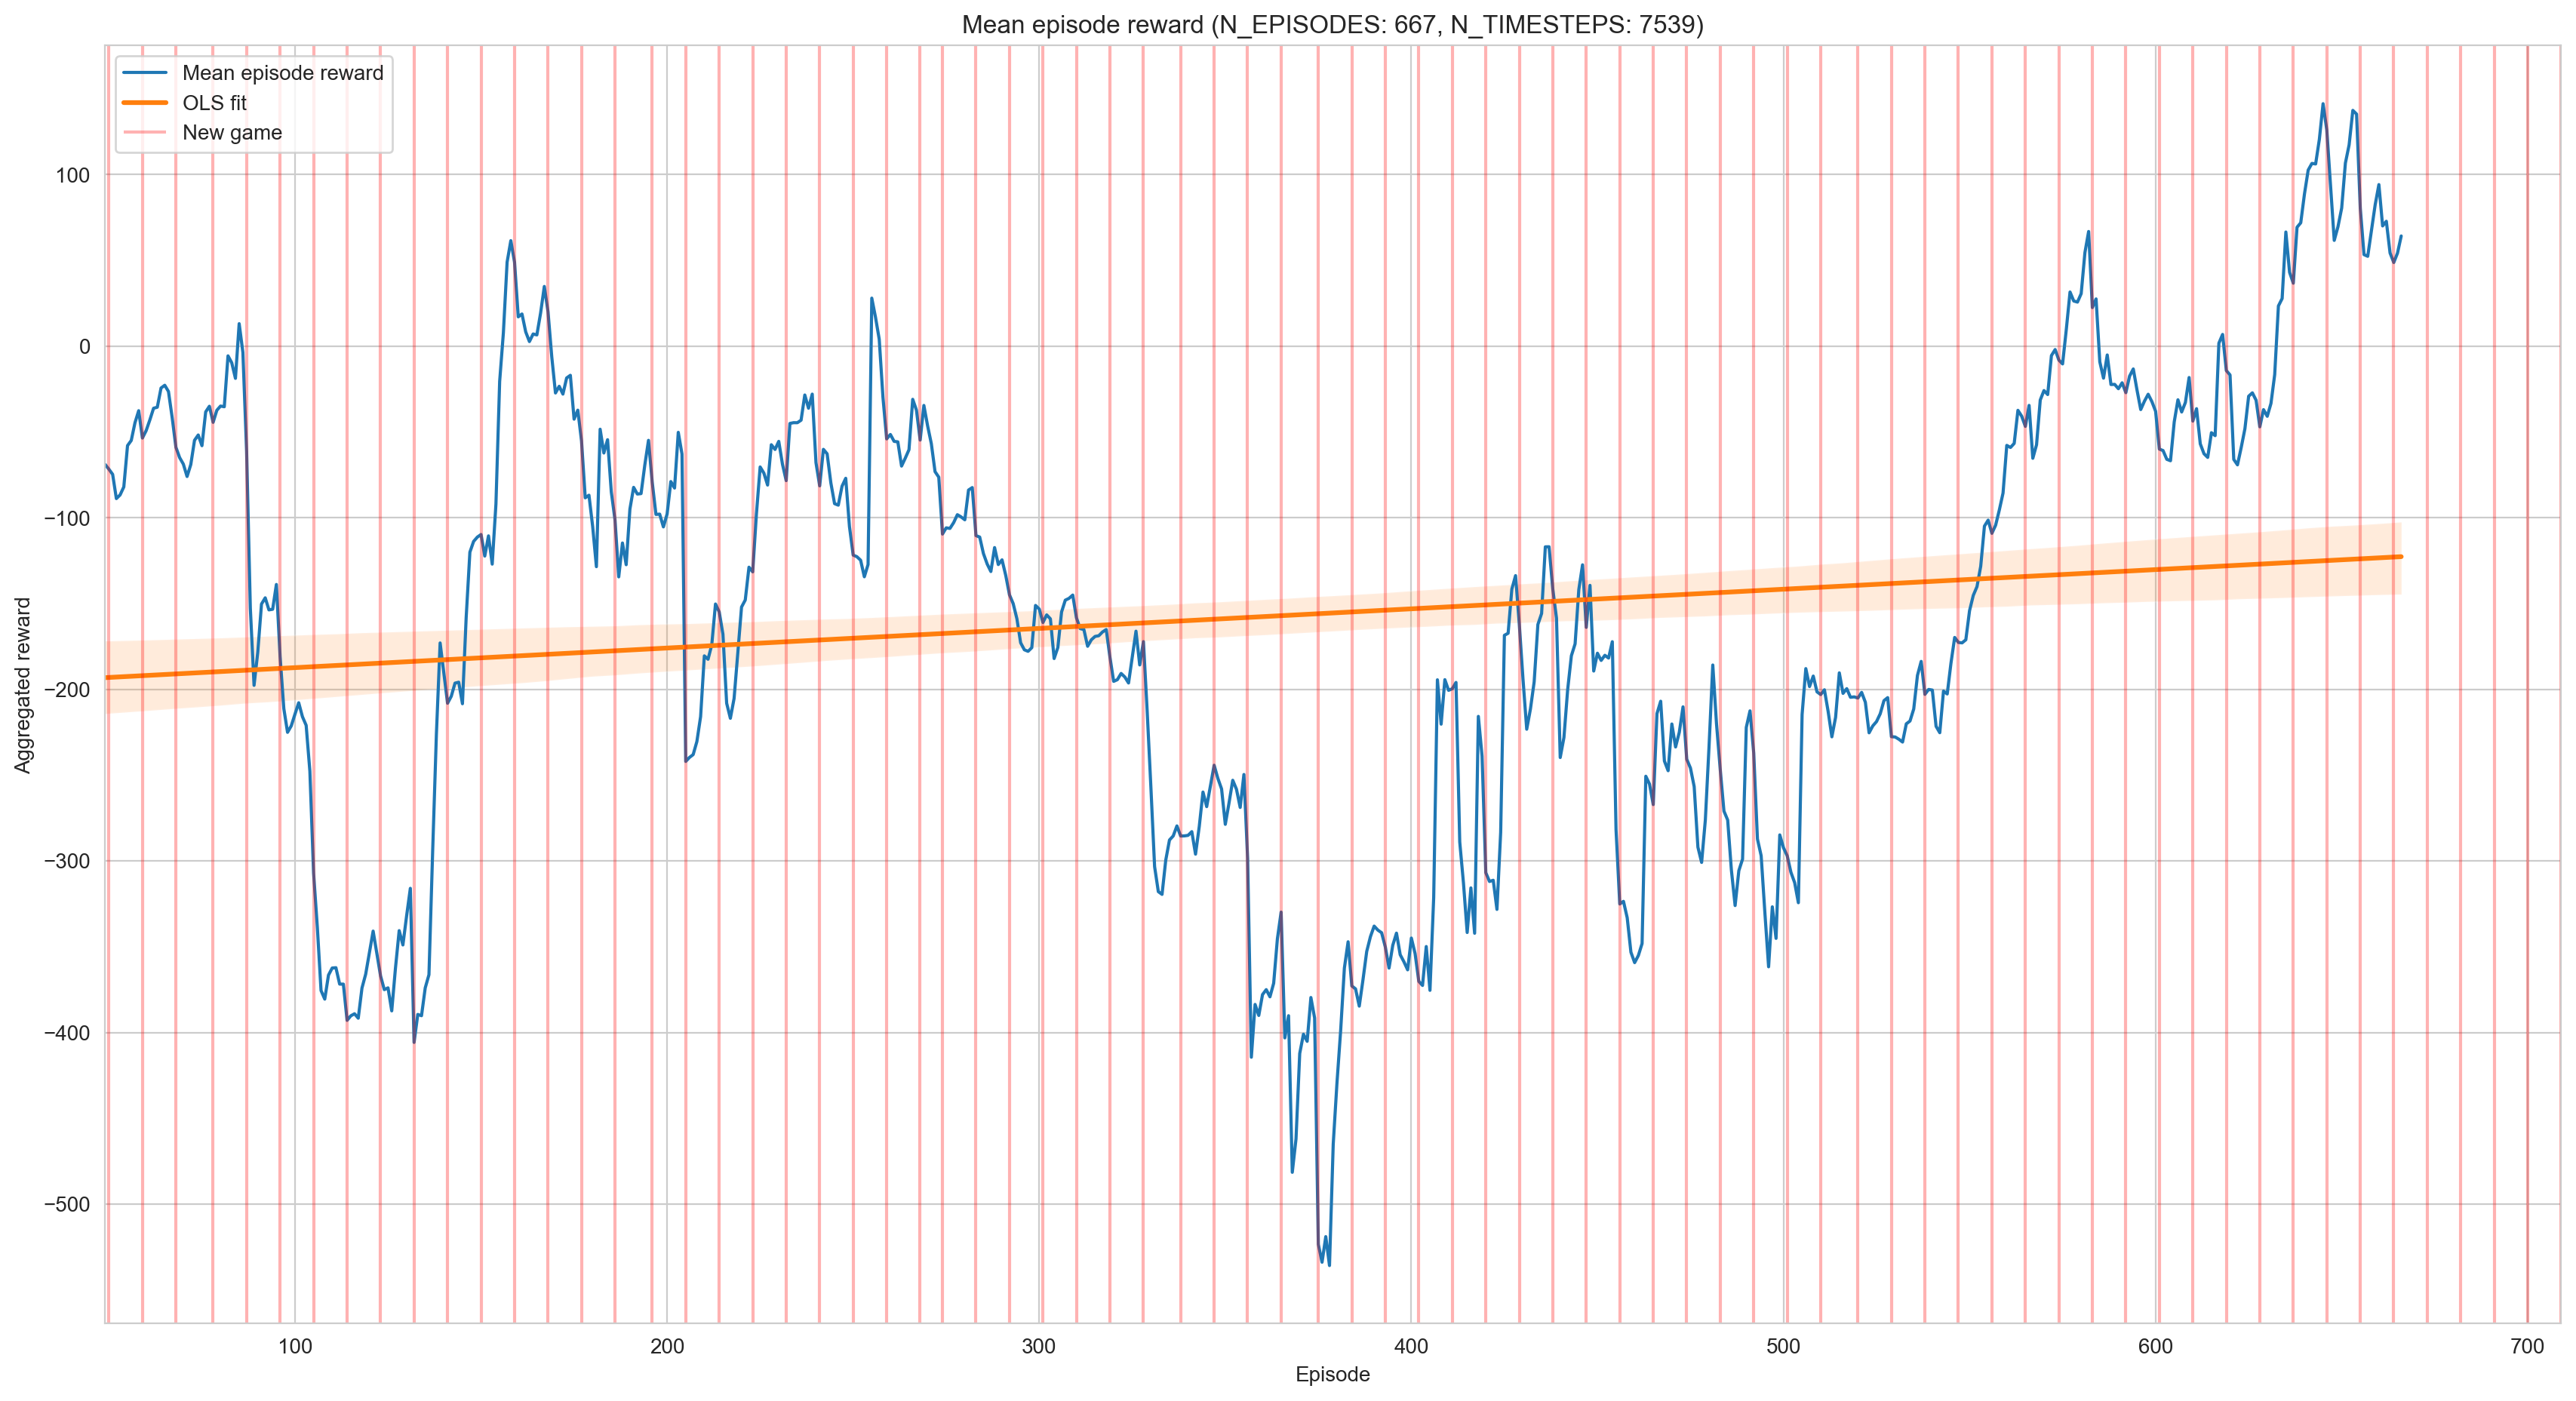

In [33]:
plot_mean_episode_reward_reg(df_reward, df_action, window_size=50)

In [34]:
def plot_mean_reward_per_action(df_reward):
    fig, ax = plt.subplots(figsize=(21, 11))
    df_reward = df_reward.copy().dropna()  # Avoid overwriting original df
    df_reward["last_tariff_rate_action"] = df_reward["last_tariff_rate_action"].astype(np.uint8)
    mean_reward_per_action = df_reward[["last_tariff_rate_action", "reward"]].groupby("last_tariff_rate_action").mean()
    sns.barplot(
        x=mean_reward_per_action.index,
        y="reward",
        data=mean_reward_per_action,
        ax=ax,
        order=ACTION_VALUE_MAPPING.values(),
    )
    ax.set_xticklabels(ACTION_VALUE_MAPPING.keys())
    ax.set_xlabel("Action")
    ax.set_ylabel("Mean reward associated with the action")
    ax.set_title(f"Mean reward per action")

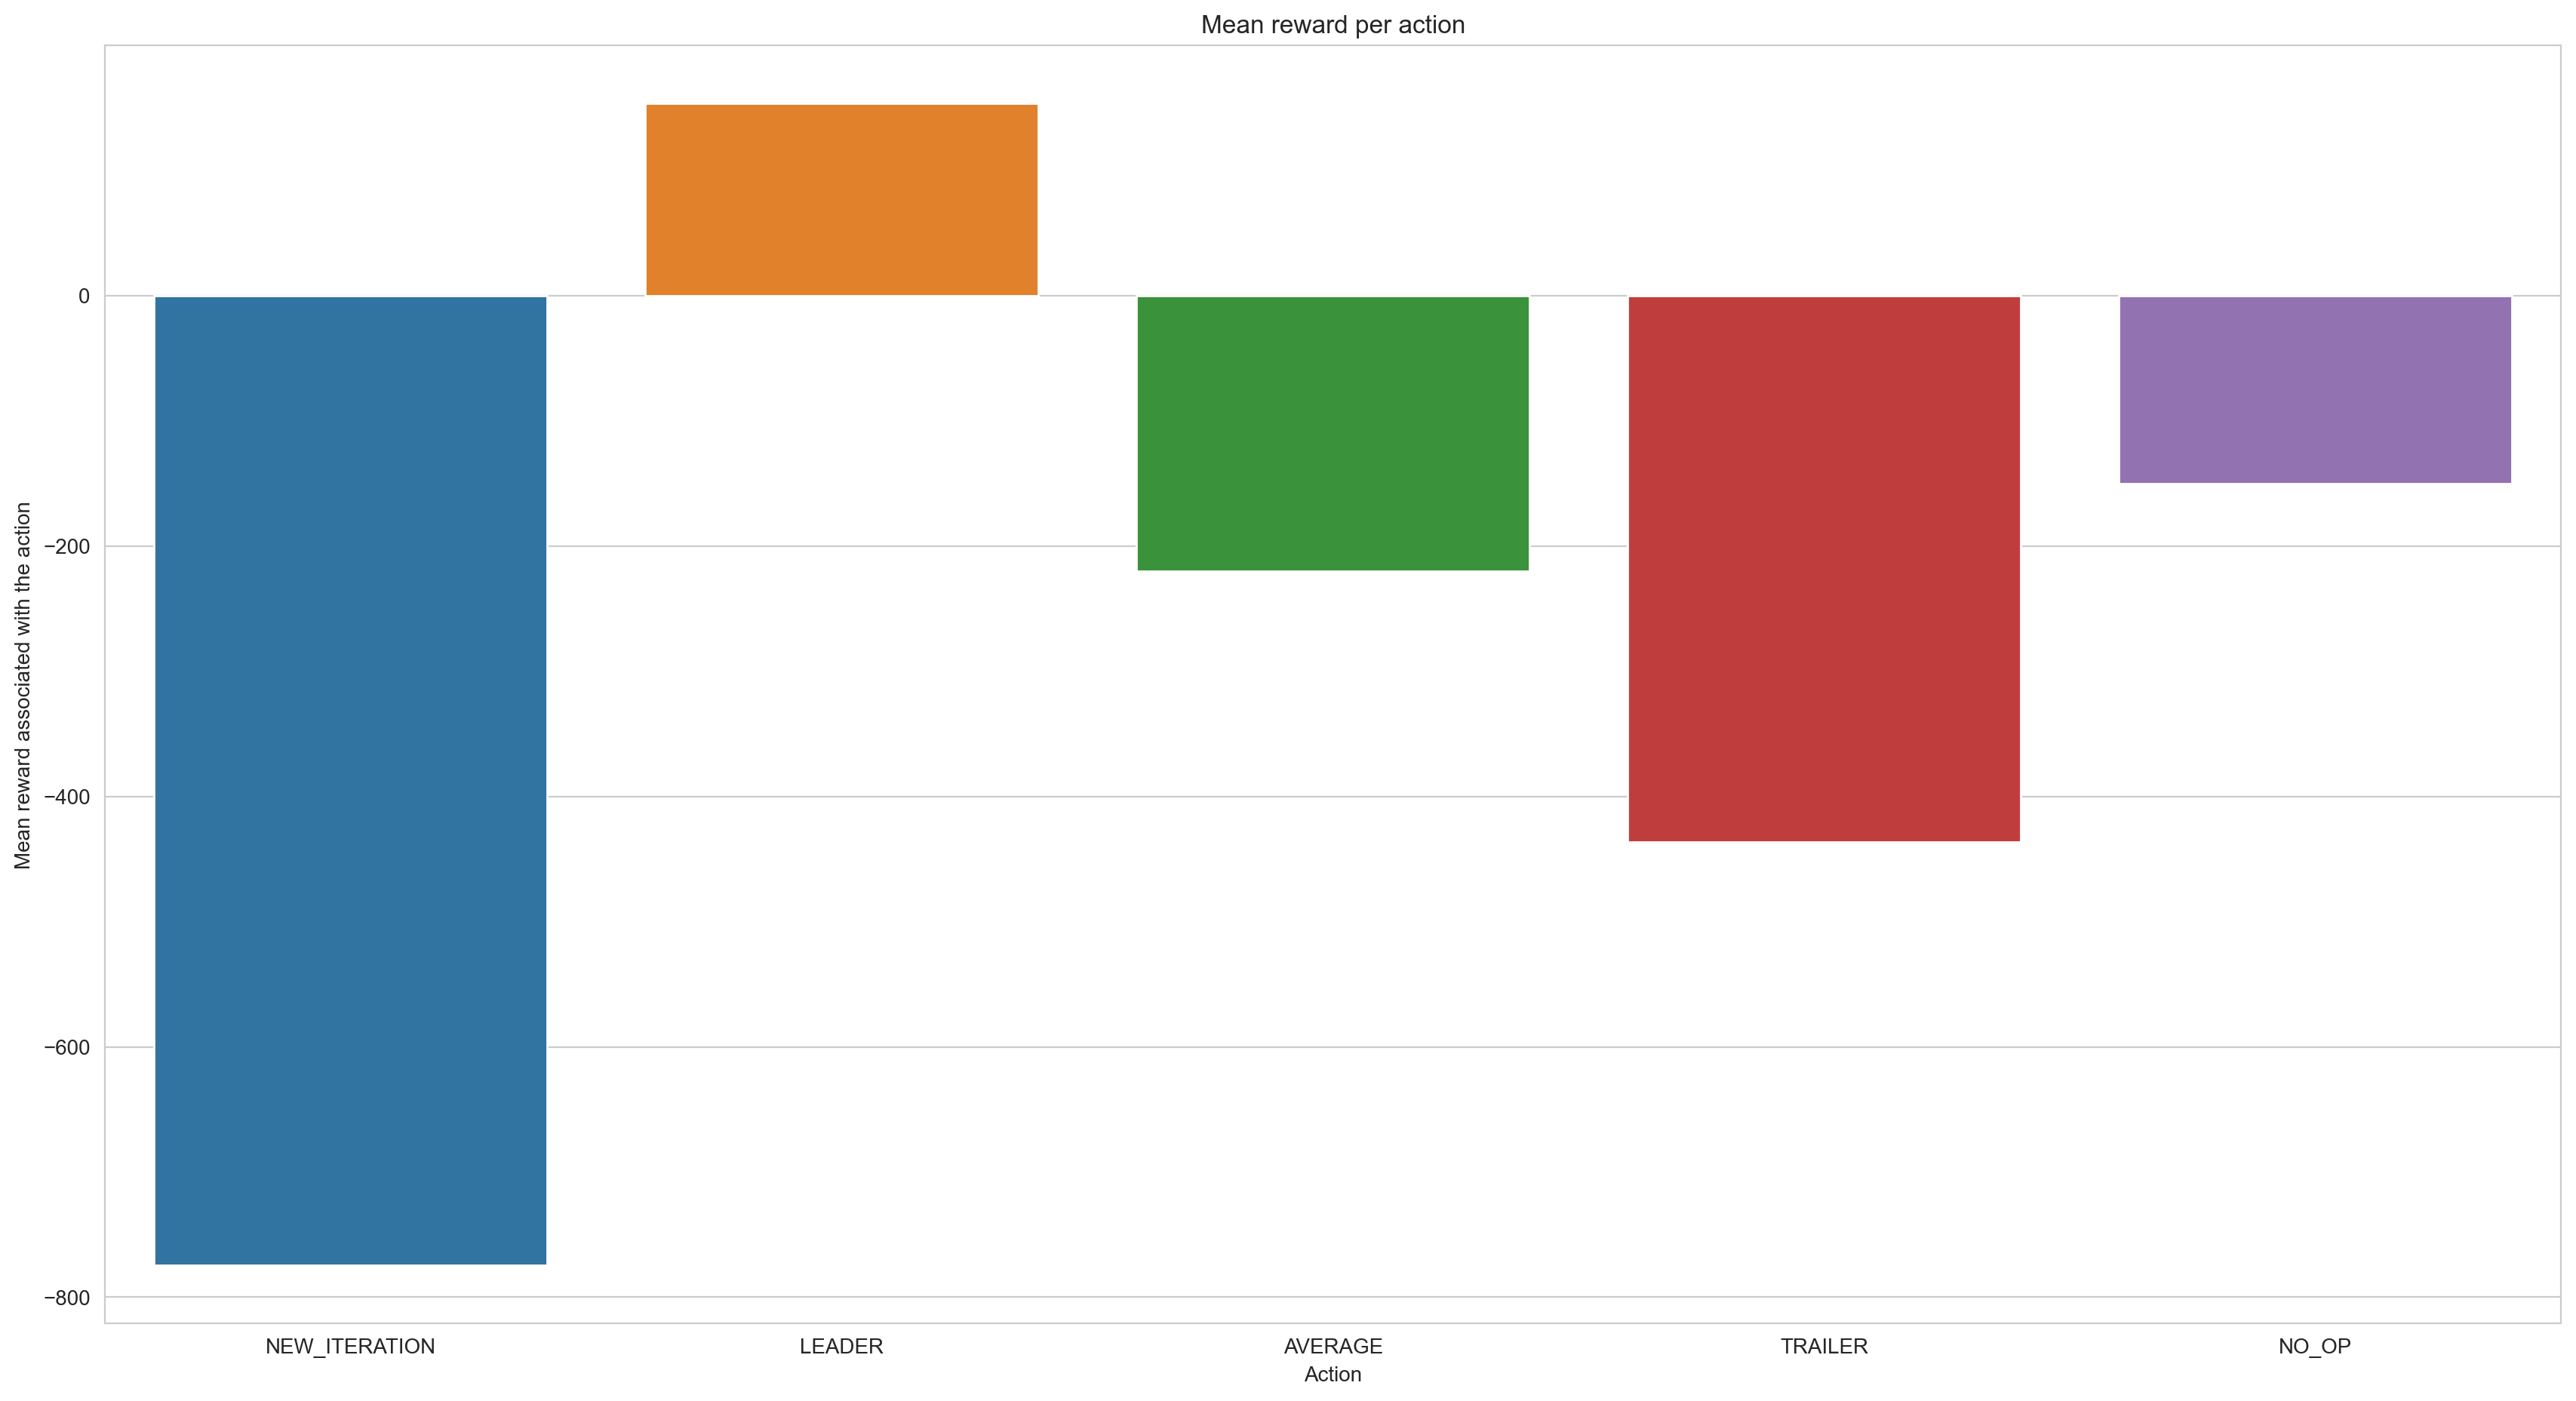

In [35]:
plot_mean_reward_per_action(df_reward)

In [36]:
def plot_reward_correlation_matrix(df_reward):
    fig, ax = plt.subplots(figsize=(14, 14))
    corr = df_reward.drop(columns=["timeslot", "gameId", *Reward.__fields__.keys()]).corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    cmap = sns.diverging_palette(230, 20, as_cmap=True)
    sns.heatmap(corr, mask=mask, cmap=cmap, annot=True, square=True, ax=ax)
    ax.set_title("Correlation of state space and reward function")

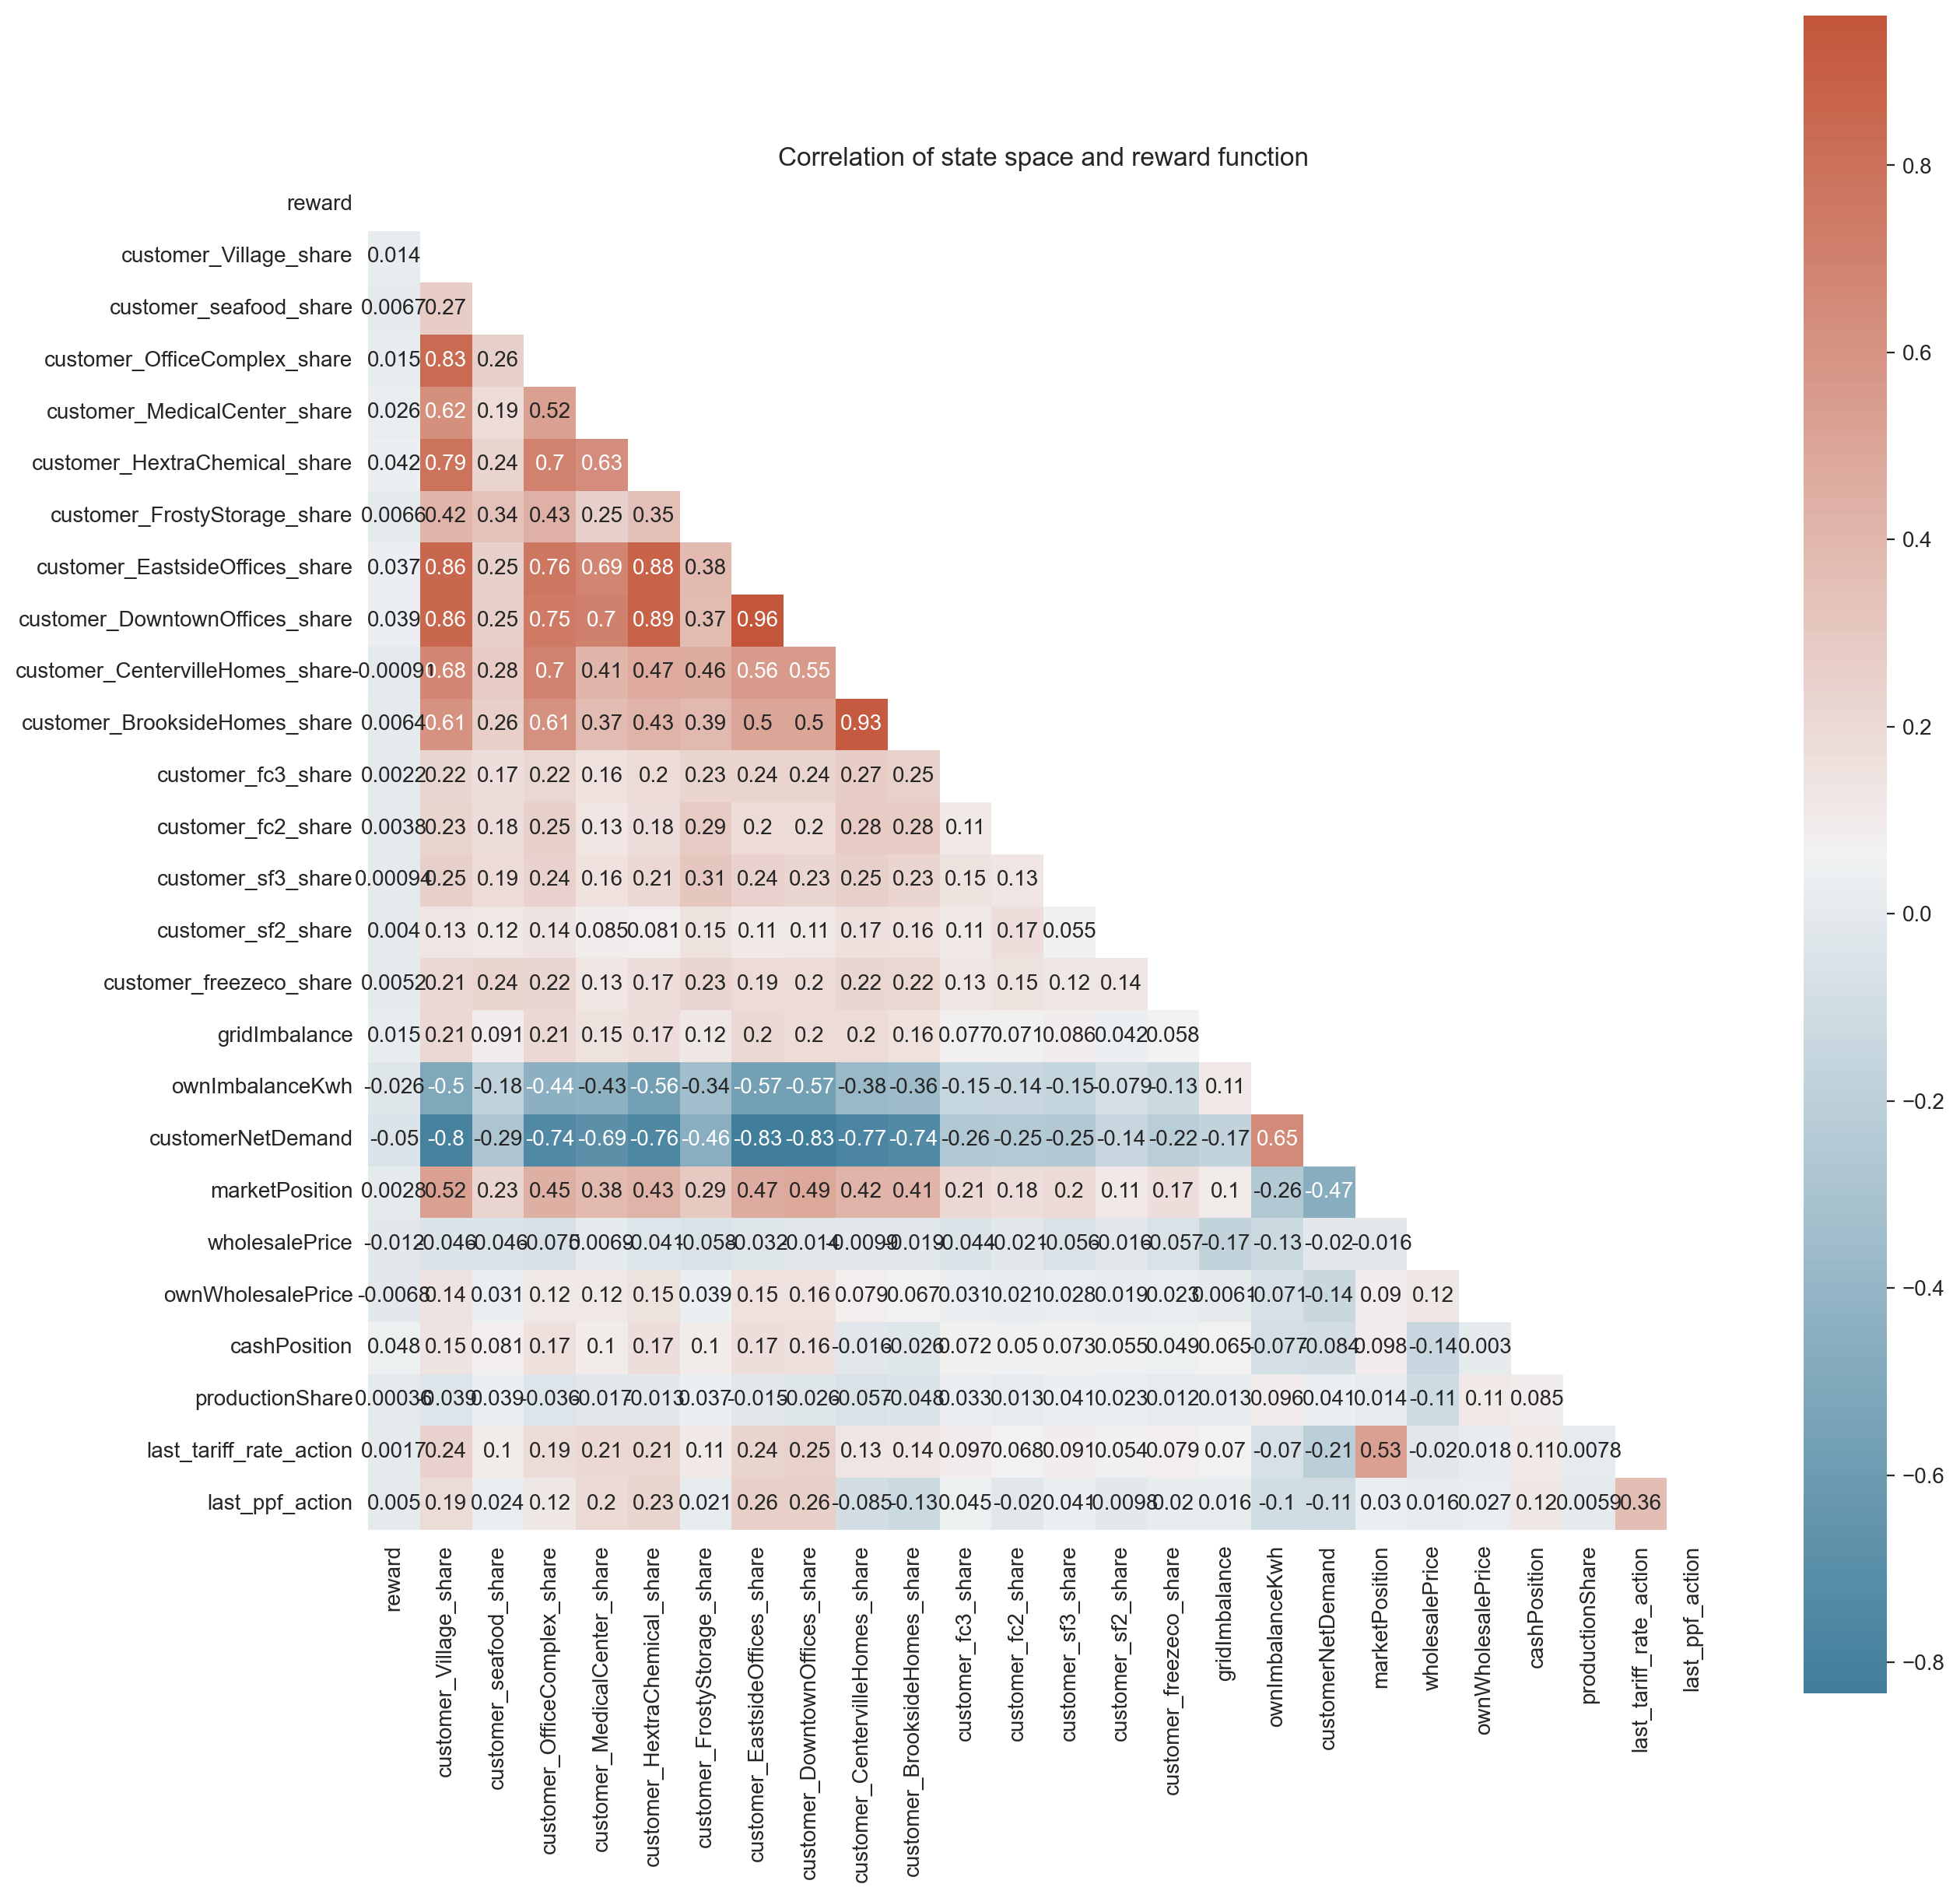

In [37]:
plot_reward_correlation_matrix(df_reward)